# Load X values

In [1]:
import os
dir = [x[0] for x in os.walk('/Users/apple/Desktop/eeglab14_1_2b/participant')]
dir.sort()
dir.reverse()
dir.pop()
dir.reverse()
print(len(dir))

32


In [2]:
import glob
filenames = []
for x in dir:
    temp = glob.glob(x + "/*.png")
    temp.sort()
    filenames.append(temp)
print(len(filenames))

32


In [3]:
from matplotlib import image
from matplotlib import pyplot
import numpy as np
from PIL import Image
X = []
for i in range(len(filenames)):
    for j in range(int(len(filenames[i]) / 2)):
        #print(len(filenames[i]))
        #print(j)
        data = Image.open(filenames[i].pop())
        arr = np.array(data)
        result = np.zeros((32,32))
        toadd = np.zeros((32,32,4))
        for k in range(arr.shape[2]):
            result[:arr[:,:,k].shape[0],:arr[:,:,k].shape[1]] = arr[:,:,k] 
            toadd[:,:,k] = result
        #print(data.shape)
        X.append(toadd)
print(len(X))
print(X[1].shape)

1280
(32, 32, 4)


# Load Y

In [4]:
import pandas as pd
df = pd.read_csv('/Users/apple/Desktop/eeglab14_1_2b/participant_ratings.csv',
                sep=r'\s*,\s*',engine = 'python', na_values = '?')
df.dropna()
Y_chart = pd.get_dummies(df, drop_first=True)
Y = Y_chart['Arousal'].tolist()
print(len(Y))
#print(Y)

1280


In [5]:
for i in range(len(Y)):
    if Y[i] < 5:
        Y[i] = 0
    else:
        Y[i] = 1
print(len(Y))

1280


# Training and Testing

In [6]:
from random import shuffle
XY = []
for i in range(len(X)):
    XY.append((X[i], Y[i]))
shuffle(XY)
print(len(XY))

1280


In [7]:
X = [x[0] for x in XY]
Y = [x[1] for x in XY]

In [8]:
import numpy as np
Xarray = np.asarray(X)
Yarray = np.asarray(Y)
print(Xarray.shape)
print(Yarray.shape)

(1280, 32, 32, 4)
(1280,)


In [9]:
X_train = Xarray[:1240,:,:,:]
Y_train = Yarray[:1240]
print(X_train.shape)
print(Y_train.shape)
X_test = Xarray[1240:,:,:]
Y_test = Yarray[1240:]
print(X_test.shape)
print(Y_test.shape)

(1240, 32, 32, 4)
(1240,)
(40, 32, 32, 4)
(40,)


In [10]:
print('Image dataset have shape =', X_train.shape)
print('Image dataset has min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(X_train.min(),
                        X_train.mean(), X_train.std(), X_train.max()))
print('')
print('Train label has shape =', Y_train.shape)
print('Training label has min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(Y_train.min(),
                        Y_train.mean(), Y_train.std(), Y_train.max()))

Image dataset have shape = (1240, 32, 32, 4)
Image dataset has min/mean/std/max = 1.00/142.08/78.38/255.00

Train label has shape = (1240,)
Training label has min/mean/std/max = 0.00/0.59/0.49/1.00


In [11]:
def normalize_data(data): 
    data = data / data.max()
    return data

X_train = normalize_data(X_train)
X_test = normalize_data(X_test)
print('Image dataset have shape =', X_train.shape)
print('Image dataset has min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(X_train.min(),
                        X_train.mean(), X_train.std(), X_train.max()))
print('')
print('Train label has shape =', Y_train.shape)
print('Training label has min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(Y_train.min(),
                        Y_train.mean(), Y_train.std(), Y_train.max()))

Image dataset have shape = (1240, 32, 32, 4)
Image dataset has min/mean/std/max = 0.00/0.56/0.31/1.00

Train label has shape = (1240,)
Training label has min/mean/std/max = 0.00/0.59/0.49/1.00


# Visualization

In [12]:
print(len(Y_train))
X_train_0 = X_train[:,:,:,0]
X_train_1 = X_train[:,:,:,1]
X_train_2 = X_train[:,:,:,2]
X_train_3 = X_train[:,:,:,3]
X_train = X_train[:,:,:,0:3]
X_test = X_test[:,:,:,0:3]
print(X_train_0.shape)
print(len(Y_test))
print(X_test.shape)
print(X_train.shape)

1240
(1240, 32, 32)
40
(40, 32, 32, 3)
(1240, 32, 32, 3)


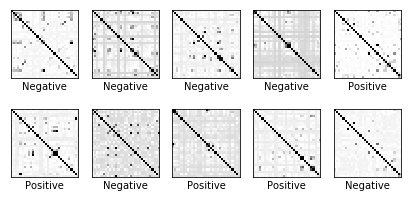

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
class_names = ['Positive', 'Negative']
plt.figure(figsize=(7,7))
for i in range(10):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_0[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[Y_train[i]])
plt.show()

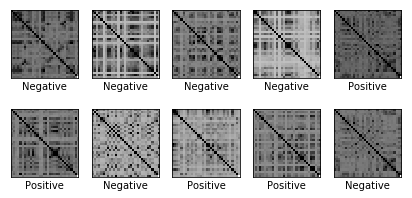

In [14]:
plt.figure(figsize=(7,7))
for i in range(10):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_1[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[Y_train[i]])
plt.show()

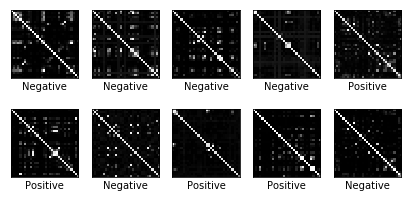

In [15]:
plt.figure(figsize=(7,7))
for i in range(10):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_2[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[Y_train[i]])
plt.show()

In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils

In [17]:
transform = transforms.Compose(
 [transforms.ToTensor(),
 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
tensor_x = torch.stack([torch.Tensor(i) for i in X_train]) # transform to torch tensors
tensor_y = torch.from_numpy(Y_train)
trainset = utils.TensorDataset(tensor_x,tensor_y) # create your datset
trainloader = utils.DataLoader(trainset,  batch_size= 40)
tensor_x_test = torch.stack([torch.Tensor(i) for i in X_test]) # transform to torch tensors
tensor_y_test = torch.from_numpy(Y_test)
testset = utils.TensorDataset(tensor_x_test,tensor_y_test) # create your datset
testloader = utils.DataLoader(testset,  batch_size=40)
device = torch.device("cpu")
classes = ('Positive', 'Negative')

torch.Size([40, 32, 32, 3])
torch.Size([40, 3, 32, 32])
3
32
32


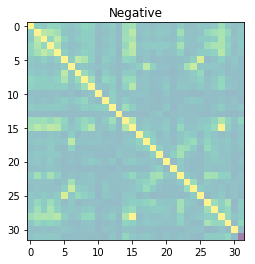

In [18]:
def imshow(img):
    img = img / 2 + 0.5 # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.size())
images = images.permute(0, 3, 1, 2)
print(images.size())
temp = images.numpy()
print(len(temp[0]))
print(len(temp[0][0]))
print(len(temp[0][0][0]))

# Show images.
rows = 1
columns = 1
fig=plt.figure()
for i in range(1):
    fig.add_subplot(rows, columns, i+1)
    plt.title(classes[labels[i]])
    img = images[i] / 2 + 0.5     # this is for unnormalize the image
    img = torchvision.transforms.ToPILImage()(img)
    plt.imshow(img)
plt.show()

# My Attempt

In [19]:
num_classes = 2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 3, padding=1)
        self.fc1 = nn.Linear(20 * 8 * 8, 100)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1280, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [20]:
loss_func = nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr=0.0005)
#opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
avg_losses = [] 
epochs = 1000 
print_freq = 15 
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.permute(0, 3, 1, 2)
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        opt.step()
        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several minibatches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0
print('Finished Training.')

[epoch: 0, i:    14] avg mini-batch loss: 0.676
[epoch: 0, i:    29] avg mini-batch loss: 0.685
[epoch: 1, i:    14] avg mini-batch loss: 0.674
[epoch: 1, i:    29] avg mini-batch loss: 0.683
[epoch: 2, i:    14] avg mini-batch loss: 0.671
[epoch: 2, i:    29] avg mini-batch loss: 0.681
[epoch: 3, i:    14] avg mini-batch loss: 0.669
[epoch: 3, i:    29] avg mini-batch loss: 0.678
[epoch: 4, i:    14] avg mini-batch loss: 0.666
[epoch: 4, i:    29] avg mini-batch loss: 0.674
[epoch: 5, i:    14] avg mini-batch loss: 0.662
[epoch: 5, i:    29] avg mini-batch loss: 0.668
[epoch: 6, i:    14] avg mini-batch loss: 0.658
[epoch: 6, i:    29] avg mini-batch loss: 0.662
[epoch: 7, i:    14] avg mini-batch loss: 0.654
[epoch: 7, i:    29] avg mini-batch loss: 0.656
[epoch: 8, i:    14] avg mini-batch loss: 0.650
[epoch: 8, i:    29] avg mini-batch loss: 0.650
[epoch: 9, i:    14] avg mini-batch loss: 0.648
[epoch: 9, i:    29] avg mini-batch loss: 0.645
[epoch: 10, i:    14] avg mini-batch los

[epoch: 84, i:    14] avg mini-batch loss: 0.508
[epoch: 84, i:    29] avg mini-batch loss: 0.503
[epoch: 85, i:    14] avg mini-batch loss: 0.502
[epoch: 85, i:    29] avg mini-batch loss: 0.498
[epoch: 86, i:    14] avg mini-batch loss: 0.498
[epoch: 86, i:    29] avg mini-batch loss: 0.493
[epoch: 87, i:    14] avg mini-batch loss: 0.495
[epoch: 87, i:    29] avg mini-batch loss: 0.489
[epoch: 88, i:    14] avg mini-batch loss: 0.491
[epoch: 88, i:    29] avg mini-batch loss: 0.487
[epoch: 89, i:    14] avg mini-batch loss: 0.488
[epoch: 89, i:    29] avg mini-batch loss: 0.484
[epoch: 90, i:    14] avg mini-batch loss: 0.484
[epoch: 90, i:    29] avg mini-batch loss: 0.481
[epoch: 91, i:    14] avg mini-batch loss: 0.480
[epoch: 91, i:    29] avg mini-batch loss: 0.481
[epoch: 92, i:    14] avg mini-batch loss: 0.477
[epoch: 92, i:    29] avg mini-batch loss: 0.479
[epoch: 93, i:    14] avg mini-batch loss: 0.478
[epoch: 93, i:    29] avg mini-batch loss: 0.480
[epoch: 94, i:    14

[epoch: 166, i:    29] avg mini-batch loss: 0.234
[epoch: 167, i:    14] avg mini-batch loss: 0.217
[epoch: 167, i:    29] avg mini-batch loss: 0.235
[epoch: 168, i:    14] avg mini-batch loss: 0.216
[epoch: 168, i:    29] avg mini-batch loss: 0.232
[epoch: 169, i:    14] avg mini-batch loss: 0.216
[epoch: 169, i:    29] avg mini-batch loss: 0.231
[epoch: 170, i:    14] avg mini-batch loss: 0.216
[epoch: 170, i:    29] avg mini-batch loss: 0.231
[epoch: 171, i:    14] avg mini-batch loss: 0.213
[epoch: 171, i:    29] avg mini-batch loss: 0.228
[epoch: 172, i:    14] avg mini-batch loss: 0.210
[epoch: 172, i:    29] avg mini-batch loss: 0.224
[epoch: 173, i:    14] avg mini-batch loss: 0.208
[epoch: 173, i:    29] avg mini-batch loss: 0.223
[epoch: 174, i:    14] avg mini-batch loss: 0.206
[epoch: 174, i:    29] avg mini-batch loss: 0.223
[epoch: 175, i:    14] avg mini-batch loss: 0.206
[epoch: 175, i:    29] avg mini-batch loss: 0.222
[epoch: 176, i:    14] avg mini-batch loss: 0.201


[epoch: 248, i:    29] avg mini-batch loss: 0.103
[epoch: 249, i:    14] avg mini-batch loss: 0.104
[epoch: 249, i:    29] avg mini-batch loss: 0.098
[epoch: 250, i:    14] avg mini-batch loss: 0.100
[epoch: 250, i:    29] avg mini-batch loss: 0.095
[epoch: 251, i:    14] avg mini-batch loss: 0.098
[epoch: 251, i:    29] avg mini-batch loss: 0.092
[epoch: 252, i:    14] avg mini-batch loss: 0.095
[epoch: 252, i:    29] avg mini-batch loss: 0.091
[epoch: 253, i:    14] avg mini-batch loss: 0.092
[epoch: 253, i:    29] avg mini-batch loss: 0.088
[epoch: 254, i:    14] avg mini-batch loss: 0.090
[epoch: 254, i:    29] avg mini-batch loss: 0.087
[epoch: 255, i:    14] avg mini-batch loss: 0.089
[epoch: 255, i:    29] avg mini-batch loss: 0.087
[epoch: 256, i:    14] avg mini-batch loss: 0.088
[epoch: 256, i:    29] avg mini-batch loss: 0.085
[epoch: 257, i:    14] avg mini-batch loss: 0.087
[epoch: 257, i:    29] avg mini-batch loss: 0.084
[epoch: 258, i:    14] avg mini-batch loss: 0.085


[epoch: 330, i:    29] avg mini-batch loss: 0.128
[epoch: 331, i:    14] avg mini-batch loss: 0.115
[epoch: 331, i:    29] avg mini-batch loss: 0.122
[epoch: 332, i:    14] avg mini-batch loss: 0.090
[epoch: 332, i:    29] avg mini-batch loss: 0.078
[epoch: 333, i:    14] avg mini-batch loss: 0.054
[epoch: 333, i:    29] avg mini-batch loss: 0.048
[epoch: 334, i:    14] avg mini-batch loss: 0.053
[epoch: 334, i:    29] avg mini-batch loss: 0.054
[epoch: 335, i:    14] avg mini-batch loss: 0.054
[epoch: 335, i:    29] avg mini-batch loss: 0.054
[epoch: 336, i:    14] avg mini-batch loss: 0.044
[epoch: 336, i:    29] avg mini-batch loss: 0.042
[epoch: 337, i:    14] avg mini-batch loss: 0.051
[epoch: 337, i:    29] avg mini-batch loss: 0.051
[epoch: 338, i:    14] avg mini-batch loss: 0.052
[epoch: 338, i:    29] avg mini-batch loss: 0.052
[epoch: 339, i:    14] avg mini-batch loss: 0.054
[epoch: 339, i:    29] avg mini-batch loss: 0.053
[epoch: 340, i:    14] avg mini-batch loss: 0.052


[epoch: 412, i:    29] avg mini-batch loss: 0.009
[epoch: 413, i:    14] avg mini-batch loss: 0.010
[epoch: 413, i:    29] avg mini-batch loss: 0.009
[epoch: 414, i:    14] avg mini-batch loss: 0.010
[epoch: 414, i:    29] avg mini-batch loss: 0.009
[epoch: 415, i:    14] avg mini-batch loss: 0.010
[epoch: 415, i:    29] avg mini-batch loss: 0.009
[epoch: 416, i:    14] avg mini-batch loss: 0.010
[epoch: 416, i:    29] avg mini-batch loss: 0.009
[epoch: 417, i:    14] avg mini-batch loss: 0.010
[epoch: 417, i:    29] avg mini-batch loss: 0.009
[epoch: 418, i:    14] avg mini-batch loss: 0.009
[epoch: 418, i:    29] avg mini-batch loss: 0.008
[epoch: 419, i:    14] avg mini-batch loss: 0.009
[epoch: 419, i:    29] avg mini-batch loss: 0.008
[epoch: 420, i:    14] avg mini-batch loss: 0.009
[epoch: 420, i:    29] avg mini-batch loss: 0.008
[epoch: 421, i:    14] avg mini-batch loss: 0.009
[epoch: 421, i:    29] avg mini-batch loss: 0.008
[epoch: 422, i:    14] avg mini-batch loss: 0.009


[epoch: 494, i:    29] avg mini-batch loss: 0.002
[epoch: 495, i:    14] avg mini-batch loss: 0.002
[epoch: 495, i:    29] avg mini-batch loss: 0.002
[epoch: 496, i:    14] avg mini-batch loss: 0.002
[epoch: 496, i:    29] avg mini-batch loss: 0.002
[epoch: 497, i:    14] avg mini-batch loss: 0.002
[epoch: 497, i:    29] avg mini-batch loss: 0.002
[epoch: 498, i:    14] avg mini-batch loss: 0.002
[epoch: 498, i:    29] avg mini-batch loss: 0.002
[epoch: 499, i:    14] avg mini-batch loss: 0.002
[epoch: 499, i:    29] avg mini-batch loss: 0.002
[epoch: 500, i:    14] avg mini-batch loss: 0.002
[epoch: 500, i:    29] avg mini-batch loss: 0.002
[epoch: 501, i:    14] avg mini-batch loss: 0.002
[epoch: 501, i:    29] avg mini-batch loss: 0.002
[epoch: 502, i:    14] avg mini-batch loss: 0.002
[epoch: 502, i:    29] avg mini-batch loss: 0.002
[epoch: 503, i:    14] avg mini-batch loss: 0.002
[epoch: 503, i:    29] avg mini-batch loss: 0.002
[epoch: 504, i:    14] avg mini-batch loss: 0.002


[epoch: 576, i:    29] avg mini-batch loss: 0.000
[epoch: 577, i:    14] avg mini-batch loss: 0.001
[epoch: 577, i:    29] avg mini-batch loss: 0.000
[epoch: 578, i:    14] avg mini-batch loss: 0.001
[epoch: 578, i:    29] avg mini-batch loss: 0.000
[epoch: 579, i:    14] avg mini-batch loss: 0.000
[epoch: 579, i:    29] avg mini-batch loss: 0.000
[epoch: 580, i:    14] avg mini-batch loss: 0.000
[epoch: 580, i:    29] avg mini-batch loss: 0.000
[epoch: 581, i:    14] avg mini-batch loss: 0.000
[epoch: 581, i:    29] avg mini-batch loss: 0.000
[epoch: 582, i:    14] avg mini-batch loss: 0.000
[epoch: 582, i:    29] avg mini-batch loss: 0.000
[epoch: 583, i:    14] avg mini-batch loss: 0.000
[epoch: 583, i:    29] avg mini-batch loss: 0.000
[epoch: 584, i:    14] avg mini-batch loss: 0.000
[epoch: 584, i:    29] avg mini-batch loss: 0.000
[epoch: 585, i:    14] avg mini-batch loss: 0.000
[epoch: 585, i:    29] avg mini-batch loss: 0.000
[epoch: 586, i:    14] avg mini-batch loss: 0.000


[epoch: 658, i:    29] avg mini-batch loss: 0.007
[epoch: 659, i:    14] avg mini-batch loss: 0.007
[epoch: 659, i:    29] avg mini-batch loss: 0.007
[epoch: 660, i:    14] avg mini-batch loss: 0.006
[epoch: 660, i:    29] avg mini-batch loss: 0.007
[epoch: 661, i:    14] avg mini-batch loss: 0.006
[epoch: 661, i:    29] avg mini-batch loss: 0.007
[epoch: 662, i:    14] avg mini-batch loss: 0.006
[epoch: 662, i:    29] avg mini-batch loss: 0.007
[epoch: 663, i:    14] avg mini-batch loss: 0.006
[epoch: 663, i:    29] avg mini-batch loss: 0.007
[epoch: 664, i:    14] avg mini-batch loss: 0.006
[epoch: 664, i:    29] avg mini-batch loss: 0.007
[epoch: 665, i:    14] avg mini-batch loss: 0.007
[epoch: 665, i:    29] avg mini-batch loss: 0.006
[epoch: 666, i:    14] avg mini-batch loss: 0.007
[epoch: 666, i:    29] avg mini-batch loss: 0.006
[epoch: 667, i:    14] avg mini-batch loss: 0.007
[epoch: 667, i:    29] avg mini-batch loss: 0.034
[epoch: 668, i:    14] avg mini-batch loss: 0.011


[epoch: 740, i:    29] avg mini-batch loss: 0.001
[epoch: 741, i:    14] avg mini-batch loss: 0.001
[epoch: 741, i:    29] avg mini-batch loss: 0.001
[epoch: 742, i:    14] avg mini-batch loss: 0.001
[epoch: 742, i:    29] avg mini-batch loss: 0.001
[epoch: 743, i:    14] avg mini-batch loss: 0.001
[epoch: 743, i:    29] avg mini-batch loss: 0.001
[epoch: 744, i:    14] avg mini-batch loss: 0.001
[epoch: 744, i:    29] avg mini-batch loss: 0.001
[epoch: 745, i:    14] avg mini-batch loss: 0.001
[epoch: 745, i:    29] avg mini-batch loss: 0.001
[epoch: 746, i:    14] avg mini-batch loss: 0.001
[epoch: 746, i:    29] avg mini-batch loss: 0.001
[epoch: 747, i:    14] avg mini-batch loss: 0.001
[epoch: 747, i:    29] avg mini-batch loss: 0.001
[epoch: 748, i:    14] avg mini-batch loss: 0.001
[epoch: 748, i:    29] avg mini-batch loss: 0.001
[epoch: 749, i:    14] avg mini-batch loss: 0.001
[epoch: 749, i:    29] avg mini-batch loss: 0.001
[epoch: 750, i:    14] avg mini-batch loss: 0.001


[epoch: 822, i:    29] avg mini-batch loss: 0.001
[epoch: 823, i:    14] avg mini-batch loss: 0.001
[epoch: 823, i:    29] avg mini-batch loss: 0.001
[epoch: 824, i:    14] avg mini-batch loss: 0.001
[epoch: 824, i:    29] avg mini-batch loss: 0.001
[epoch: 825, i:    14] avg mini-batch loss: 0.001
[epoch: 825, i:    29] avg mini-batch loss: 0.001
[epoch: 826, i:    14] avg mini-batch loss: 0.001
[epoch: 826, i:    29] avg mini-batch loss: 0.001
[epoch: 827, i:    14] avg mini-batch loss: 0.001
[epoch: 827, i:    29] avg mini-batch loss: 0.001
[epoch: 828, i:    14] avg mini-batch loss: 0.001
[epoch: 828, i:    29] avg mini-batch loss: 0.001
[epoch: 829, i:    14] avg mini-batch loss: 0.001
[epoch: 829, i:    29] avg mini-batch loss: 0.001
[epoch: 830, i:    14] avg mini-batch loss: 0.001
[epoch: 830, i:    29] avg mini-batch loss: 0.001
[epoch: 831, i:    14] avg mini-batch loss: 0.001
[epoch: 831, i:    29] avg mini-batch loss: 0.001
[epoch: 832, i:    14] avg mini-batch loss: 0.001


[epoch: 904, i:    29] avg mini-batch loss: 0.000
[epoch: 905, i:    14] avg mini-batch loss: 0.000
[epoch: 905, i:    29] avg mini-batch loss: 0.000
[epoch: 906, i:    14] avg mini-batch loss: 0.000
[epoch: 906, i:    29] avg mini-batch loss: 0.000
[epoch: 907, i:    14] avg mini-batch loss: 0.000
[epoch: 907, i:    29] avg mini-batch loss: 0.000
[epoch: 908, i:    14] avg mini-batch loss: 0.000
[epoch: 908, i:    29] avg mini-batch loss: 0.000
[epoch: 909, i:    14] avg mini-batch loss: 0.000
[epoch: 909, i:    29] avg mini-batch loss: 0.000
[epoch: 910, i:    14] avg mini-batch loss: 0.000
[epoch: 910, i:    29] avg mini-batch loss: 0.000
[epoch: 911, i:    14] avg mini-batch loss: 0.000
[epoch: 911, i:    29] avg mini-batch loss: 0.000
[epoch: 912, i:    14] avg mini-batch loss: 0.000
[epoch: 912, i:    29] avg mini-batch loss: 0.000
[epoch: 913, i:    14] avg mini-batch loss: 0.000
[epoch: 913, i:    29] avg mini-batch loss: 0.000
[epoch: 914, i:    14] avg mini-batch loss: 0.000


[epoch: 986, i:    29] avg mini-batch loss: 0.000
[epoch: 987, i:    14] avg mini-batch loss: 0.000
[epoch: 987, i:    29] avg mini-batch loss: 0.000
[epoch: 988, i:    14] avg mini-batch loss: 0.000
[epoch: 988, i:    29] avg mini-batch loss: 0.000
[epoch: 989, i:    14] avg mini-batch loss: 0.000
[epoch: 989, i:    29] avg mini-batch loss: 0.000
[epoch: 990, i:    14] avg mini-batch loss: 0.000
[epoch: 990, i:    29] avg mini-batch loss: 0.000
[epoch: 991, i:    14] avg mini-batch loss: 0.000
[epoch: 991, i:    29] avg mini-batch loss: 0.000
[epoch: 992, i:    14] avg mini-batch loss: 0.000
[epoch: 992, i:    29] avg mini-batch loss: 0.000
[epoch: 993, i:    14] avg mini-batch loss: 0.000
[epoch: 993, i:    29] avg mini-batch loss: 0.000
[epoch: 994, i:    14] avg mini-batch loss: 0.000
[epoch: 994, i:    29] avg mini-batch loss: 0.000
[epoch: 995, i:    14] avg mini-batch loss: 0.000
[epoch: 995, i:    29] avg mini-batch loss: 0.000
[epoch: 996, i:    14] avg mini-batch loss: 0.000


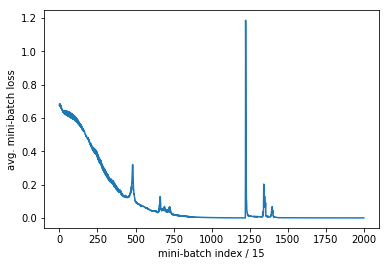

In [21]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [22]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(total)
print('Accuracy of the network on the 40 test images: %d %%' % (100 * correct / total))

40
Accuracy of the network on the 40 test images: 62 %


In [23]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(40):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(2):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Positive : 64 %
Accuracy of Negative : 61 %


In [24]:
transform = transforms.Compose(
 [transforms.ToTensor(),
 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
tensor_x = torch.stack([torch.Tensor(i) for i in X_train]) # transform to torch tensors
tensor_y = torch.from_numpy(Y_train)
trainset = utils.TensorDataset(tensor_x,tensor_y) # create your datset
trainloader = utils.DataLoader(trainset,  batch_size= 40)
tensor_x_test = torch.stack([torch.Tensor(i) for i in X_test]) # transform to torch tensors
tensor_y_test = torch.from_numpy(Y_test)
testset = utils.TensorDataset(tensor_x_test,tensor_y_test) # create your datset
testloader = utils.DataLoader(testset,  batch_size=40)
device = torch.device("cpu")
classes = ('Positive', 'Negative')

In [25]:
num_classes = 2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 3, padding=1)
        self.fc1 = nn.Linear(20 * 8 * 8, 100)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
net = Net()
net.to(device)

loss_func = nn.CrossEntropyLoss()

opt = optim.Adadelta(net.parameters(), lr=0.5, rho=0.9, eps=1e-06, weight_decay=0)
avg_losses = [] 
epochs = 500 
print_freq = 15 
for epoch in range(epochs):
    running_loss = 0.0 
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.permute(0, 3, 1, 2)
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        opt.step()
        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several minibatches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0
print('Finished Training.')

[epoch: 0, i:    14] avg mini-batch loss: 0.677
[epoch: 0, i:    29] avg mini-batch loss: 0.689
[epoch: 1, i:    14] avg mini-batch loss: 0.675
[epoch: 1, i:    29] avg mini-batch loss: 0.687
[epoch: 2, i:    14] avg mini-batch loss: 0.674
[epoch: 2, i:    29] avg mini-batch loss: 0.686
[epoch: 3, i:    14] avg mini-batch loss: 0.673
[epoch: 3, i:    29] avg mini-batch loss: 0.686
[epoch: 4, i:    14] avg mini-batch loss: 0.673
[epoch: 4, i:    29] avg mini-batch loss: 0.685
[epoch: 5, i:    14] avg mini-batch loss: 0.672
[epoch: 5, i:    29] avg mini-batch loss: 0.685
[epoch: 6, i:    14] avg mini-batch loss: 0.672
[epoch: 6, i:    29] avg mini-batch loss: 0.684
[epoch: 7, i:    14] avg mini-batch loss: 0.671
[epoch: 7, i:    29] avg mini-batch loss: 0.684
[epoch: 8, i:    14] avg mini-batch loss: 0.671
[epoch: 8, i:    29] avg mini-batch loss: 0.683
[epoch: 9, i:    14] avg mini-batch loss: 0.670
[epoch: 9, i:    29] avg mini-batch loss: 0.682
[epoch: 10, i:    14] avg mini-batch los

[epoch: 84, i:    14] avg mini-batch loss: 0.486
[epoch: 84, i:    29] avg mini-batch loss: 0.506
[epoch: 85, i:    14] avg mini-batch loss: 0.483
[epoch: 85, i:    29] avg mini-batch loss: 0.502
[epoch: 86, i:    14] avg mini-batch loss: 0.481
[epoch: 86, i:    29] avg mini-batch loss: 0.499
[epoch: 87, i:    14] avg mini-batch loss: 0.475
[epoch: 87, i:    29] avg mini-batch loss: 0.494
[epoch: 88, i:    14] avg mini-batch loss: 0.473
[epoch: 88, i:    29] avg mini-batch loss: 0.490
[epoch: 89, i:    14] avg mini-batch loss: 0.472
[epoch: 89, i:    29] avg mini-batch loss: 0.485
[epoch: 90, i:    14] avg mini-batch loss: 0.462
[epoch: 90, i:    29] avg mini-batch loss: 0.478
[epoch: 91, i:    14] avg mini-batch loss: 0.460
[epoch: 91, i:    29] avg mini-batch loss: 0.478
[epoch: 92, i:    14] avg mini-batch loss: 0.454
[epoch: 92, i:    29] avg mini-batch loss: 0.476
[epoch: 93, i:    14] avg mini-batch loss: 0.449
[epoch: 93, i:    29] avg mini-batch loss: 0.469
[epoch: 94, i:    14

[epoch: 166, i:    29] avg mini-batch loss: 0.186
[epoch: 167, i:    14] avg mini-batch loss: 0.170
[epoch: 167, i:    29] avg mini-batch loss: 0.188
[epoch: 168, i:    14] avg mini-batch loss: 0.150
[epoch: 168, i:    29] avg mini-batch loss: 0.287
[epoch: 169, i:    14] avg mini-batch loss: 0.278
[epoch: 169, i:    29] avg mini-batch loss: 0.186
[epoch: 170, i:    14] avg mini-batch loss: 0.143
[epoch: 170, i:    29] avg mini-batch loss: 0.166
[epoch: 171, i:    14] avg mini-batch loss: 0.157
[epoch: 171, i:    29] avg mini-batch loss: 0.213
[epoch: 172, i:    14] avg mini-batch loss: 0.181
[epoch: 172, i:    29] avg mini-batch loss: 0.241
[epoch: 173, i:    14] avg mini-batch loss: 0.271
[epoch: 173, i:    29] avg mini-batch loss: 0.176
[epoch: 174, i:    14] avg mini-batch loss: 0.136
[epoch: 174, i:    29] avg mini-batch loss: 0.166
[epoch: 175, i:    14] avg mini-batch loss: 0.213
[epoch: 175, i:    29] avg mini-batch loss: 0.154
[epoch: 176, i:    14] avg mini-batch loss: 0.141


[epoch: 248, i:    29] avg mini-batch loss: 0.308
[epoch: 249, i:    14] avg mini-batch loss: 0.067
[epoch: 249, i:    29] avg mini-batch loss: 0.087
[epoch: 250, i:    14] avg mini-batch loss: 0.051
[epoch: 250, i:    29] avg mini-batch loss: 0.062
[epoch: 251, i:    14] avg mini-batch loss: 0.038
[epoch: 251, i:    29] avg mini-batch loss: 0.085
[epoch: 252, i:    14] avg mini-batch loss: 0.039
[epoch: 252, i:    29] avg mini-batch loss: 0.093
[epoch: 253, i:    14] avg mini-batch loss: 0.084
[epoch: 253, i:    29] avg mini-batch loss: 0.068
[epoch: 254, i:    14] avg mini-batch loss: 0.045
[epoch: 254, i:    29] avg mini-batch loss: 0.158
[epoch: 255, i:    14] avg mini-batch loss: 0.051
[epoch: 255, i:    29] avg mini-batch loss: 0.076
[epoch: 256, i:    14] avg mini-batch loss: 0.052
[epoch: 256, i:    29] avg mini-batch loss: 0.055
[epoch: 257, i:    14] avg mini-batch loss: 0.052
[epoch: 257, i:    29] avg mini-batch loss: 0.135
[epoch: 258, i:    14] avg mini-batch loss: 0.045


[epoch: 330, i:    29] avg mini-batch loss: 0.028
[epoch: 331, i:    14] avg mini-batch loss: 0.026
[epoch: 331, i:    29] avg mini-batch loss: 0.026
[epoch: 332, i:    14] avg mini-batch loss: 0.017
[epoch: 332, i:    29] avg mini-batch loss: 0.026
[epoch: 333, i:    14] avg mini-batch loss: 0.056
[epoch: 333, i:    29] avg mini-batch loss: 0.049
[epoch: 334, i:    14] avg mini-batch loss: 0.044
[epoch: 334, i:    29] avg mini-batch loss: 0.032
[epoch: 335, i:    14] avg mini-batch loss: 0.031
[epoch: 335, i:    29] avg mini-batch loss: 0.026
[epoch: 336, i:    14] avg mini-batch loss: 0.017
[epoch: 336, i:    29] avg mini-batch loss: 0.021
[epoch: 337, i:    14] avg mini-batch loss: 0.013
[epoch: 337, i:    29] avg mini-batch loss: 0.036
[epoch: 338, i:    14] avg mini-batch loss: 0.235
[epoch: 338, i:    29] avg mini-batch loss: 0.040
[epoch: 339, i:    14] avg mini-batch loss: 0.023
[epoch: 339, i:    29] avg mini-batch loss: 0.027
[epoch: 340, i:    14] avg mini-batch loss: 0.018


[epoch: 412, i:    29] avg mini-batch loss: 0.021
[epoch: 413, i:    14] avg mini-batch loss: 0.015
[epoch: 413, i:    29] avg mini-batch loss: 0.014
[epoch: 414, i:    14] avg mini-batch loss: 0.008
[epoch: 414, i:    29] avg mini-batch loss: 0.090
[epoch: 415, i:    14] avg mini-batch loss: 0.099
[epoch: 415, i:    29] avg mini-batch loss: 0.043
[epoch: 416, i:    14] avg mini-batch loss: 0.012
[epoch: 416, i:    29] avg mini-batch loss: 0.026
[epoch: 417, i:    14] avg mini-batch loss: 0.015
[epoch: 417, i:    29] avg mini-batch loss: 0.013
[epoch: 418, i:    14] avg mini-batch loss: 0.009
[epoch: 418, i:    29] avg mini-batch loss: 0.020
[epoch: 419, i:    14] avg mini-batch loss: 0.010
[epoch: 419, i:    29] avg mini-batch loss: 0.007
[epoch: 420, i:    14] avg mini-batch loss: 0.009
[epoch: 420, i:    29] avg mini-batch loss: 0.012
[epoch: 421, i:    14] avg mini-batch loss: 0.005
[epoch: 421, i:    29] avg mini-batch loss: 0.013
[epoch: 422, i:    14] avg mini-batch loss: 0.006


[epoch: 494, i:    29] avg mini-batch loss: 0.003
[epoch: 495, i:    14] avg mini-batch loss: 0.002
[epoch: 495, i:    29] avg mini-batch loss: 0.002
[epoch: 496, i:    14] avg mini-batch loss: 0.004
[epoch: 496, i:    29] avg mini-batch loss: 0.114
[epoch: 497, i:    14] avg mini-batch loss: 0.081
[epoch: 497, i:    29] avg mini-batch loss: 0.462
[epoch: 498, i:    14] avg mini-batch loss: 0.059
[epoch: 498, i:    29] avg mini-batch loss: 0.015
[epoch: 499, i:    14] avg mini-batch loss: 0.011
[epoch: 499, i:    29] avg mini-batch loss: 0.008
Finished Training.


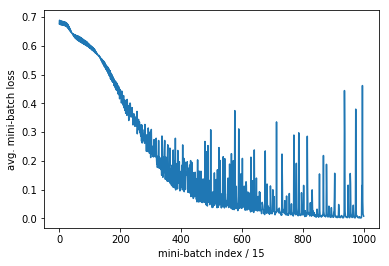

In [26]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [27]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(total)
print('Accuracy of the network on the 40 test images: %d %%' % (100 * correct / total))

40
Accuracy of the network on the 40 test images: 60 %


In [28]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(40):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(2):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Positive : 35 %
Accuracy of Negative : 73 %


# LeNET

In [29]:
transform = transforms.Compose(
 [transforms.ToTensor(),
 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
tensor_x = torch.stack([torch.Tensor(i) for i in X_train]) # transform to torch tensors
tensor_y = torch.from_numpy(Y_train)
trainset = utils.TensorDataset(tensor_x,tensor_y) # create your datset
trainloader = utils.DataLoader(trainset,  batch_size= 40)
tensor_x_test = torch.stack([torch.Tensor(i) for i in X_test]) # transform to torch tensors
tensor_y_test = torch.from_numpy(Y_test)
testset = utils.TensorDataset(tensor_x_test,tensor_y_test) # create your datset
testloader = utils.DataLoader(testset,  batch_size=40)
device = torch.device("cpu")
classes = ('Positive', 'Negative')

In [30]:
num_classes = 2

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # input channel = 3, output channel = 6, kernel_size = 5
        # input size = (32, 32), output size = (28, 28)
        self.conv1 = nn.Conv2d(3, 6, 5)
        # input channel = 6, output channel = 16, kernel_size = 5
        # input size = (14, 14), output size = (10, 10)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # input dim = 16*5*5, output dim = 120
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # input dim = 120, output dim = 40
        self.fc2 = nn.Linear(120, 40)
        # input dim = 40, output dim = 2
        self.fc3 = nn.Linear(40, num_classes)

    def forward(self, x):
        # pool size = 2
        # input size = (28, 28), output size = (14, 14), output channel = 6
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        # pool size = 2
        # input size = (10, 10), output size = (5, 5), output channel = 16
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # flatten as one dimension
        x = x.view(x.shape[0], -1)
        # input dim = 16*5*5, output dim = 120
        x = F.relu(self.fc1(x))
        # input dim = 120, output dim = 40
        x = F.relu(self.fc2(x))
        # input dim = 40, output dim = 2
        x = self.fc3(x)
        return x
    
net = Net().to(device)

In [31]:
loss_func = nn.CrossEntropyLoss()
# We use stochastic gradient descent (SGD) as optimizer.
opt = torch.optim.Adam(net.parameters(), lr=0.0005)
avg_losses = [] # Avg. losses.
epochs = 1000 # Total epochs.
print_freq = 15 # Print frequency.
for epoch in range(epochs): # Loop over the dataset multiple times.
    running_loss = 0.0 # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        inputs = inputs.permute(0, 3, 1, 2)
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients.
        opt.zero_grad()
        # Forward step.
        outputs = net(inputs)
        #print(outputs)
        #print(labels)
        loss = loss_func(outputs, labels)

        # Backward step.
        loss.backward()

        # Optimization step (update the parameters).
        opt.step()
        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several minibatches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0
print('Finished Training.')

[epoch: 0, i:    14] avg mini-batch loss: 0.700
[epoch: 0, i:    29] avg mini-batch loss: 0.688
[epoch: 1, i:    14] avg mini-batch loss: 0.673
[epoch: 1, i:    29] avg mini-batch loss: 0.684
[epoch: 2, i:    14] avg mini-batch loss: 0.674
[epoch: 2, i:    29] avg mini-batch loss: 0.683
[epoch: 3, i:    14] avg mini-batch loss: 0.673
[epoch: 3, i:    29] avg mini-batch loss: 0.683
[epoch: 4, i:    14] avg mini-batch loss: 0.673
[epoch: 4, i:    29] avg mini-batch loss: 0.683
[epoch: 5, i:    14] avg mini-batch loss: 0.672
[epoch: 5, i:    29] avg mini-batch loss: 0.683
[epoch: 6, i:    14] avg mini-batch loss: 0.672
[epoch: 6, i:    29] avg mini-batch loss: 0.682
[epoch: 7, i:    14] avg mini-batch loss: 0.672
[epoch: 7, i:    29] avg mini-batch loss: 0.682
[epoch: 8, i:    14] avg mini-batch loss: 0.671
[epoch: 8, i:    29] avg mini-batch loss: 0.682
[epoch: 9, i:    14] avg mini-batch loss: 0.671
[epoch: 9, i:    29] avg mini-batch loss: 0.682
[epoch: 10, i:    14] avg mini-batch los

[epoch: 84, i:    14] avg mini-batch loss: 0.572
[epoch: 84, i:    29] avg mini-batch loss: 0.564
[epoch: 85, i:    14] avg mini-batch loss: 0.570
[epoch: 85, i:    29] avg mini-batch loss: 0.558
[epoch: 86, i:    14] avg mini-batch loss: 0.566
[epoch: 86, i:    29] avg mini-batch loss: 0.558
[epoch: 87, i:    14] avg mini-batch loss: 0.559
[epoch: 87, i:    29] avg mini-batch loss: 0.554
[epoch: 88, i:    14] avg mini-batch loss: 0.558
[epoch: 88, i:    29] avg mini-batch loss: 0.553
[epoch: 89, i:    14] avg mini-batch loss: 0.553
[epoch: 89, i:    29] avg mini-batch loss: 0.556
[epoch: 90, i:    14] avg mini-batch loss: 0.556
[epoch: 90, i:    29] avg mini-batch loss: 0.552
[epoch: 91, i:    14] avg mini-batch loss: 0.556
[epoch: 91, i:    29] avg mini-batch loss: 0.548
[epoch: 92, i:    14] avg mini-batch loss: 0.551
[epoch: 92, i:    29] avg mini-batch loss: 0.549
[epoch: 93, i:    14] avg mini-batch loss: 0.558
[epoch: 93, i:    29] avg mini-batch loss: 0.556
[epoch: 94, i:    14

[epoch: 166, i:    29] avg mini-batch loss: 0.313
[epoch: 167, i:    14] avg mini-batch loss: 0.256
[epoch: 167, i:    29] avg mini-batch loss: 0.309
[epoch: 168, i:    14] avg mini-batch loss: 0.255
[epoch: 168, i:    29] avg mini-batch loss: 0.305
[epoch: 169, i:    14] avg mini-batch loss: 0.254
[epoch: 169, i:    29] avg mini-batch loss: 0.305
[epoch: 170, i:    14] avg mini-batch loss: 0.256
[epoch: 170, i:    29] avg mini-batch loss: 0.301
[epoch: 171, i:    14] avg mini-batch loss: 0.248
[epoch: 171, i:    29] avg mini-batch loss: 0.310
[epoch: 172, i:    14] avg mini-batch loss: 0.251
[epoch: 172, i:    29] avg mini-batch loss: 0.297
[epoch: 173, i:    14] avg mini-batch loss: 0.237
[epoch: 173, i:    29] avg mini-batch loss: 0.289
[epoch: 174, i:    14] avg mini-batch loss: 0.237
[epoch: 174, i:    29] avg mini-batch loss: 0.297
[epoch: 175, i:    14] avg mini-batch loss: 0.236
[epoch: 175, i:    29] avg mini-batch loss: 0.288
[epoch: 176, i:    14] avg mini-batch loss: 0.232


[epoch: 248, i:    29] avg mini-batch loss: 0.201
[epoch: 249, i:    14] avg mini-batch loss: 0.168
[epoch: 249, i:    29] avg mini-batch loss: 0.251
[epoch: 250, i:    14] avg mini-batch loss: 0.157
[epoch: 250, i:    29] avg mini-batch loss: 0.170
[epoch: 251, i:    14] avg mini-batch loss: 0.132
[epoch: 251, i:    29] avg mini-batch loss: 0.138
[epoch: 252, i:    14] avg mini-batch loss: 0.130
[epoch: 252, i:    29] avg mini-batch loss: 0.116
[epoch: 253, i:    14] avg mini-batch loss: 0.119
[epoch: 253, i:    29] avg mini-batch loss: 0.148
[epoch: 254, i:    14] avg mini-batch loss: 0.121
[epoch: 254, i:    29] avg mini-batch loss: 0.178
[epoch: 255, i:    14] avg mini-batch loss: 0.125
[epoch: 255, i:    29] avg mini-batch loss: 0.167
[epoch: 256, i:    14] avg mini-batch loss: 0.130
[epoch: 256, i:    29] avg mini-batch loss: 0.146
[epoch: 257, i:    14] avg mini-batch loss: 0.137
[epoch: 257, i:    29] avg mini-batch loss: 0.124
[epoch: 258, i:    14] avg mini-batch loss: 0.131


[epoch: 330, i:    29] avg mini-batch loss: 0.027
[epoch: 331, i:    14] avg mini-batch loss: 0.026
[epoch: 331, i:    29] avg mini-batch loss: 0.027
[epoch: 332, i:    14] avg mini-batch loss: 0.028
[epoch: 332, i:    29] avg mini-batch loss: 0.027
[epoch: 333, i:    14] avg mini-batch loss: 0.028
[epoch: 333, i:    29] avg mini-batch loss: 0.029
[epoch: 334, i:    14] avg mini-batch loss: 0.030
[epoch: 334, i:    29] avg mini-batch loss: 0.029
[epoch: 335, i:    14] avg mini-batch loss: 0.028
[epoch: 335, i:    29] avg mini-batch loss: 0.028
[epoch: 336, i:    14] avg mini-batch loss: 0.033
[epoch: 336, i:    29] avg mini-batch loss: 0.031
[epoch: 337, i:    14] avg mini-batch loss: 0.029
[epoch: 337, i:    29] avg mini-batch loss: 0.039
[epoch: 338, i:    14] avg mini-batch loss: 0.050
[epoch: 338, i:    29] avg mini-batch loss: 0.061
[epoch: 339, i:    14] avg mini-batch loss: 0.040
[epoch: 339, i:    29] avg mini-batch loss: 0.057
[epoch: 340, i:    14] avg mini-batch loss: 0.080


[epoch: 412, i:    29] avg mini-batch loss: 0.019
[epoch: 413, i:    14] avg mini-batch loss: 0.018
[epoch: 413, i:    29] avg mini-batch loss: 0.019
[epoch: 414, i:    14] avg mini-batch loss: 0.017
[epoch: 414, i:    29] avg mini-batch loss: 0.018
[epoch: 415, i:    14] avg mini-batch loss: 0.017
[epoch: 415, i:    29] avg mini-batch loss: 0.018
[epoch: 416, i:    14] avg mini-batch loss: 0.017
[epoch: 416, i:    29] avg mini-batch loss: 0.017
[epoch: 417, i:    14] avg mini-batch loss: 0.016
[epoch: 417, i:    29] avg mini-batch loss: 0.017
[epoch: 418, i:    14] avg mini-batch loss: 0.016
[epoch: 418, i:    29] avg mini-batch loss: 0.016
[epoch: 419, i:    14] avg mini-batch loss: 0.016
[epoch: 419, i:    29] avg mini-batch loss: 0.016
[epoch: 420, i:    14] avg mini-batch loss: 0.016
[epoch: 420, i:    29] avg mini-batch loss: 0.016
[epoch: 421, i:    14] avg mini-batch loss: 0.015
[epoch: 421, i:    29] avg mini-batch loss: 0.015
[epoch: 422, i:    14] avg mini-batch loss: 0.015


[epoch: 494, i:    29] avg mini-batch loss: 0.043
[epoch: 495, i:    14] avg mini-batch loss: 0.053
[epoch: 495, i:    29] avg mini-batch loss: 0.054
[epoch: 496, i:    14] avg mini-batch loss: 0.078
[epoch: 496, i:    29] avg mini-batch loss: 0.154
[epoch: 497, i:    14] avg mini-batch loss: 0.157
[epoch: 497, i:    29] avg mini-batch loss: 0.279
[epoch: 498, i:    14] avg mini-batch loss: 0.200
[epoch: 498, i:    29] avg mini-batch loss: 0.195
[epoch: 499, i:    14] avg mini-batch loss: 0.117
[epoch: 499, i:    29] avg mini-batch loss: 0.101
[epoch: 500, i:    14] avg mini-batch loss: 0.058
[epoch: 500, i:    29] avg mini-batch loss: 0.082
[epoch: 501, i:    14] avg mini-batch loss: 0.045
[epoch: 501, i:    29] avg mini-batch loss: 0.046
[epoch: 502, i:    14] avg mini-batch loss: 0.043
[epoch: 502, i:    29] avg mini-batch loss: 0.037
[epoch: 503, i:    14] avg mini-batch loss: 0.042
[epoch: 503, i:    29] avg mini-batch loss: 0.049
[epoch: 504, i:    14] avg mini-batch loss: 0.044


[epoch: 576, i:    29] avg mini-batch loss: 0.179
[epoch: 577, i:    14] avg mini-batch loss: 0.385
[epoch: 577, i:    29] avg mini-batch loss: 0.658
[epoch: 578, i:    14] avg mini-batch loss: 0.363
[epoch: 578, i:    29] avg mini-batch loss: 0.210
[epoch: 579, i:    14] avg mini-batch loss: 0.119
[epoch: 579, i:    29] avg mini-batch loss: 0.083
[epoch: 580, i:    14] avg mini-batch loss: 0.052
[epoch: 580, i:    29] avg mini-batch loss: 0.044
[epoch: 581, i:    14] avg mini-batch loss: 0.033
[epoch: 581, i:    29] avg mini-batch loss: 0.035
[epoch: 582, i:    14] avg mini-batch loss: 0.024
[epoch: 582, i:    29] avg mini-batch loss: 0.025
[epoch: 583, i:    14] avg mini-batch loss: 0.021
[epoch: 583, i:    29] avg mini-batch loss: 0.017
[epoch: 584, i:    14] avg mini-batch loss: 0.016
[epoch: 584, i:    29] avg mini-batch loss: 0.017
[epoch: 585, i:    14] avg mini-batch loss: 0.014
[epoch: 585, i:    29] avg mini-batch loss: 0.012
[epoch: 586, i:    14] avg mini-batch loss: 0.012


[epoch: 658, i:    29] avg mini-batch loss: 0.002
[epoch: 659, i:    14] avg mini-batch loss: 0.002
[epoch: 659, i:    29] avg mini-batch loss: 0.002
[epoch: 660, i:    14] avg mini-batch loss: 0.002
[epoch: 660, i:    29] avg mini-batch loss: 0.002
[epoch: 661, i:    14] avg mini-batch loss: 0.002
[epoch: 661, i:    29] avg mini-batch loss: 0.002
[epoch: 662, i:    14] avg mini-batch loss: 0.002
[epoch: 662, i:    29] avg mini-batch loss: 0.002
[epoch: 663, i:    14] avg mini-batch loss: 0.002
[epoch: 663, i:    29] avg mini-batch loss: 0.002
[epoch: 664, i:    14] avg mini-batch loss: 0.002
[epoch: 664, i:    29] avg mini-batch loss: 0.002
[epoch: 665, i:    14] avg mini-batch loss: 0.002
[epoch: 665, i:    29] avg mini-batch loss: 0.002
[epoch: 666, i:    14] avg mini-batch loss: 0.002
[epoch: 666, i:    29] avg mini-batch loss: 0.002
[epoch: 667, i:    14] avg mini-batch loss: 0.002
[epoch: 667, i:    29] avg mini-batch loss: 0.002
[epoch: 668, i:    14] avg mini-batch loss: 0.002


[epoch: 740, i:    29] avg mini-batch loss: 0.004
[epoch: 741, i:    14] avg mini-batch loss: 0.004
[epoch: 741, i:    29] avg mini-batch loss: 0.004
[epoch: 742, i:    14] avg mini-batch loss: 0.004
[epoch: 742, i:    29] avg mini-batch loss: 0.004
[epoch: 743, i:    14] avg mini-batch loss: 0.004
[epoch: 743, i:    29] avg mini-batch loss: 0.003
[epoch: 744, i:    14] avg mini-batch loss: 0.004
[epoch: 744, i:    29] avg mini-batch loss: 0.003
[epoch: 745, i:    14] avg mini-batch loss: 0.004
[epoch: 745, i:    29] avg mini-batch loss: 0.003
[epoch: 746, i:    14] avg mini-batch loss: 0.003
[epoch: 746, i:    29] avg mini-batch loss: 0.003
[epoch: 747, i:    14] avg mini-batch loss: 0.003
[epoch: 747, i:    29] avg mini-batch loss: 0.003
[epoch: 748, i:    14] avg mini-batch loss: 0.003
[epoch: 748, i:    29] avg mini-batch loss: 0.003
[epoch: 749, i:    14] avg mini-batch loss: 0.003
[epoch: 749, i:    29] avg mini-batch loss: 0.003
[epoch: 750, i:    14] avg mini-batch loss: 0.003


[epoch: 822, i:    29] avg mini-batch loss: 0.001
[epoch: 823, i:    14] avg mini-batch loss: 0.001
[epoch: 823, i:    29] avg mini-batch loss: 0.001
[epoch: 824, i:    14] avg mini-batch loss: 0.001
[epoch: 824, i:    29] avg mini-batch loss: 0.001
[epoch: 825, i:    14] avg mini-batch loss: 0.001
[epoch: 825, i:    29] avg mini-batch loss: 0.001
[epoch: 826, i:    14] avg mini-batch loss: 0.000
[epoch: 826, i:    29] avg mini-batch loss: 0.000
[epoch: 827, i:    14] avg mini-batch loss: 0.000
[epoch: 827, i:    29] avg mini-batch loss: 0.000
[epoch: 828, i:    14] avg mini-batch loss: 0.000
[epoch: 828, i:    29] avg mini-batch loss: 0.000
[epoch: 829, i:    14] avg mini-batch loss: 0.000
[epoch: 829, i:    29] avg mini-batch loss: 0.000
[epoch: 830, i:    14] avg mini-batch loss: 0.000
[epoch: 830, i:    29] avg mini-batch loss: 0.000
[epoch: 831, i:    14] avg mini-batch loss: 0.000
[epoch: 831, i:    29] avg mini-batch loss: 0.000
[epoch: 832, i:    14] avg mini-batch loss: 0.000


[epoch: 904, i:    29] avg mini-batch loss: 0.000
[epoch: 905, i:    14] avg mini-batch loss: 0.000
[epoch: 905, i:    29] avg mini-batch loss: 0.000
[epoch: 906, i:    14] avg mini-batch loss: 0.000
[epoch: 906, i:    29] avg mini-batch loss: 0.000
[epoch: 907, i:    14] avg mini-batch loss: 0.000
[epoch: 907, i:    29] avg mini-batch loss: 0.000
[epoch: 908, i:    14] avg mini-batch loss: 0.000
[epoch: 908, i:    29] avg mini-batch loss: 0.000
[epoch: 909, i:    14] avg mini-batch loss: 0.000
[epoch: 909, i:    29] avg mini-batch loss: 0.000
[epoch: 910, i:    14] avg mini-batch loss: 0.000
[epoch: 910, i:    29] avg mini-batch loss: 0.000
[epoch: 911, i:    14] avg mini-batch loss: 0.000
[epoch: 911, i:    29] avg mini-batch loss: 0.000
[epoch: 912, i:    14] avg mini-batch loss: 0.000
[epoch: 912, i:    29] avg mini-batch loss: 0.000
[epoch: 913, i:    14] avg mini-batch loss: 0.000
[epoch: 913, i:    29] avg mini-batch loss: 0.000
[epoch: 914, i:    14] avg mini-batch loss: 0.000


[epoch: 986, i:    29] avg mini-batch loss: 0.000
[epoch: 987, i:    14] avg mini-batch loss: 0.000
[epoch: 987, i:    29] avg mini-batch loss: 0.000
[epoch: 988, i:    14] avg mini-batch loss: 0.000
[epoch: 988, i:    29] avg mini-batch loss: 0.000
[epoch: 989, i:    14] avg mini-batch loss: 0.000
[epoch: 989, i:    29] avg mini-batch loss: 0.000
[epoch: 990, i:    14] avg mini-batch loss: 0.000
[epoch: 990, i:    29] avg mini-batch loss: 0.000
[epoch: 991, i:    14] avg mini-batch loss: 0.000
[epoch: 991, i:    29] avg mini-batch loss: 0.000
[epoch: 992, i:    14] avg mini-batch loss: 0.000
[epoch: 992, i:    29] avg mini-batch loss: 0.000
[epoch: 993, i:    14] avg mini-batch loss: 0.000
[epoch: 993, i:    29] avg mini-batch loss: 0.000
[epoch: 994, i:    14] avg mini-batch loss: 0.000
[epoch: 994, i:    29] avg mini-batch loss: 0.000
[epoch: 995, i:    14] avg mini-batch loss: 0.000
[epoch: 995, i:    29] avg mini-batch loss: 0.000
[epoch: 996, i:    14] avg mini-batch loss: 0.000


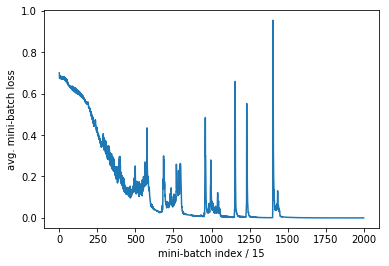

In [32]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [33]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(total)
print('Accuracy of the network on the 40 test images: %d %%' % (100 * correct / total))

40
Accuracy of the network on the 40 test images: 57 %


In [34]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(40):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(2):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Positive : 42 %
Accuracy of Negative : 65 %


In [35]:
transform = transforms.Compose(
 [transforms.ToTensor(),
 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
tensor_x = torch.stack([torch.Tensor(i) for i in X_train]) # transform to torch tensors
tensor_y = torch.from_numpy(Y_train)
trainset = utils.TensorDataset(tensor_x,tensor_y) # create your datset
trainloader = utils.DataLoader(trainset,  batch_size= 40)
tensor_x_test = torch.stack([torch.Tensor(i) for i in X_test]) # transform to torch tensors
tensor_y_test = torch.from_numpy(Y_test)
testset = utils.TensorDataset(tensor_x_test,tensor_y_test) # create your datset
testloader = utils.DataLoader(testset,  batch_size=40)
device = torch.device("cpu")
classes = ('Positive', 'Negative')

In [36]:
num_classes = 2

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # input channel = 3, output channel = 6, kernel_size = 5
        # input size = (32, 32), output size = (28, 28)
        self.conv1 = nn.Conv2d(3, 6, 5)
        # input channel = 6, output channel = 16, kernel_size = 5
        # input size = (14, 14), output size = (10, 10)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # input dim = 16*5*5, output dim = 120
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # input dim = 120, output dim = 40
        self.fc2 = nn.Linear(120, 40)
        # input dim = 40, output dim = 2
        self.fc3 = nn.Linear(40, num_classes)

    def forward(self, x):
        # pool size = 2
        # input size = (28, 28), output size = (14, 14), output channel = 6
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        # pool size = 2
        # input size = (10, 10), output size = (5, 5), output channel = 16
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # flatten as one dimension
        x = x.view(x.shape[0], -1)
        # input dim = 16*5*5, output dim = 120
        x = F.relu(self.fc1(x))
        # input dim = 120, output dim = 40
        x = F.relu(self.fc2(x))
        # input dim = 40, output dim = 2
        x = self.fc3(x)
        return x
    
net = Net().to(device)

loss_func = nn.CrossEntropyLoss()
# We use stochastic gradient descent (SGD) as optimizer.
#opt = torch.optim.Adam(net.parameters(), lr=0.001)
opt = optim.Adadelta(net.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
avg_losses = [] # Avg. losses.
epochs = 500 # Total epochs.
print_freq = 15 # Print frequency.
for epoch in range(epochs): # Loop over the dataset multiple times.
    running_loss = 0.0 # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        inputs = inputs.permute(0, 3, 1, 2)
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients.
        opt.zero_grad()
        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)

        # Backward step.
        loss.backward()

        # Optimization step (update the parameters).
        opt.step()
        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several minibatches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0
print('Finished Training.')

[epoch: 0, i:    14] avg mini-batch loss: 0.680
[epoch: 0, i:    29] avg mini-batch loss: 0.689
[epoch: 1, i:    14] avg mini-batch loss: 0.674
[epoch: 1, i:    29] avg mini-batch loss: 0.687
[epoch: 2, i:    14] avg mini-batch loss: 0.674
[epoch: 2, i:    29] avg mini-batch loss: 0.686
[epoch: 3, i:    14] avg mini-batch loss: 0.673
[epoch: 3, i:    29] avg mini-batch loss: 0.685
[epoch: 4, i:    14] avg mini-batch loss: 0.673
[epoch: 4, i:    29] avg mini-batch loss: 0.685
[epoch: 5, i:    14] avg mini-batch loss: 0.672
[epoch: 5, i:    29] avg mini-batch loss: 0.684
[epoch: 6, i:    14] avg mini-batch loss: 0.672
[epoch: 6, i:    29] avg mini-batch loss: 0.684
[epoch: 7, i:    14] avg mini-batch loss: 0.672
[epoch: 7, i:    29] avg mini-batch loss: 0.683
[epoch: 8, i:    14] avg mini-batch loss: 0.671
[epoch: 8, i:    29] avg mini-batch loss: 0.683
[epoch: 9, i:    14] avg mini-batch loss: 0.670
[epoch: 9, i:    29] avg mini-batch loss: 0.681
[epoch: 10, i:    14] avg mini-batch los

[epoch: 84, i:    14] avg mini-batch loss: 0.460
[epoch: 84, i:    29] avg mini-batch loss: 0.413
[epoch: 85, i:    14] avg mini-batch loss: 0.486
[epoch: 85, i:    29] avg mini-batch loss: 0.446
[epoch: 86, i:    14] avg mini-batch loss: 0.467
[epoch: 86, i:    29] avg mini-batch loss: 0.420
[epoch: 87, i:    14] avg mini-batch loss: 0.447
[epoch: 87, i:    29] avg mini-batch loss: 0.447
[epoch: 88, i:    14] avg mini-batch loss: 0.441
[epoch: 88, i:    29] avg mini-batch loss: 0.414
[epoch: 89, i:    14] avg mini-batch loss: 0.437
[epoch: 89, i:    29] avg mini-batch loss: 0.417
[epoch: 90, i:    14] avg mini-batch loss: 0.474
[epoch: 90, i:    29] avg mini-batch loss: 0.422
[epoch: 91, i:    14] avg mini-batch loss: 0.389
[epoch: 91, i:    29] avg mini-batch loss: 0.389
[epoch: 92, i:    14] avg mini-batch loss: 0.443
[epoch: 92, i:    29] avg mini-batch loss: 0.442
[epoch: 93, i:    14] avg mini-batch loss: 0.447
[epoch: 93, i:    29] avg mini-batch loss: 0.405
[epoch: 94, i:    14

[epoch: 166, i:    29] avg mini-batch loss: 0.264
[epoch: 167, i:    14] avg mini-batch loss: 0.278
[epoch: 167, i:    29] avg mini-batch loss: 0.192
[epoch: 168, i:    14] avg mini-batch loss: 0.333
[epoch: 168, i:    29] avg mini-batch loss: 0.243
[epoch: 169, i:    14] avg mini-batch loss: 0.302
[epoch: 169, i:    29] avg mini-batch loss: 0.219
[epoch: 170, i:    14] avg mini-batch loss: 0.187
[epoch: 170, i:    29] avg mini-batch loss: 0.204
[epoch: 171, i:    14] avg mini-batch loss: 0.239
[epoch: 171, i:    29] avg mini-batch loss: 0.265
[epoch: 172, i:    14] avg mini-batch loss: 0.290
[epoch: 172, i:    29] avg mini-batch loss: 0.331
[epoch: 173, i:    14] avg mini-batch loss: 0.183
[epoch: 173, i:    29] avg mini-batch loss: 0.192
[epoch: 174, i:    14] avg mini-batch loss: 0.235
[epoch: 174, i:    29] avg mini-batch loss: 0.206
[epoch: 175, i:    14] avg mini-batch loss: 0.248
[epoch: 175, i:    29] avg mini-batch loss: 0.185
[epoch: 176, i:    14] avg mini-batch loss: 0.181


[epoch: 248, i:    29] avg mini-batch loss: 0.143
[epoch: 249, i:    14] avg mini-batch loss: 0.130
[epoch: 249, i:    29] avg mini-batch loss: 0.110
[epoch: 250, i:    14] avg mini-batch loss: 0.132
[epoch: 250, i:    29] avg mini-batch loss: 0.152
[epoch: 251, i:    14] avg mini-batch loss: 0.173
[epoch: 251, i:    29] avg mini-batch loss: 0.110
[epoch: 252, i:    14] avg mini-batch loss: 0.110
[epoch: 252, i:    29] avg mini-batch loss: 0.071
[epoch: 253, i:    14] avg mini-batch loss: 0.206
[epoch: 253, i:    29] avg mini-batch loss: 0.087
[epoch: 254, i:    14] avg mini-batch loss: 0.134
[epoch: 254, i:    29] avg mini-batch loss: 0.105
[epoch: 255, i:    14] avg mini-batch loss: 0.084
[epoch: 255, i:    29] avg mini-batch loss: 0.074
[epoch: 256, i:    14] avg mini-batch loss: 0.122
[epoch: 256, i:    29] avg mini-batch loss: 0.148
[epoch: 257, i:    14] avg mini-batch loss: 0.088
[epoch: 257, i:    29] avg mini-batch loss: 0.093
[epoch: 258, i:    14] avg mini-batch loss: 0.098


[epoch: 330, i:    29] avg mini-batch loss: 0.048
[epoch: 331, i:    14] avg mini-batch loss: 0.140
[epoch: 331, i:    29] avg mini-batch loss: 0.080
[epoch: 332, i:    14] avg mini-batch loss: 0.073
[epoch: 332, i:    29] avg mini-batch loss: 0.161
[epoch: 333, i:    14] avg mini-batch loss: 0.116
[epoch: 333, i:    29] avg mini-batch loss: 0.065
[epoch: 334, i:    14] avg mini-batch loss: 0.022
[epoch: 334, i:    29] avg mini-batch loss: 0.083
[epoch: 335, i:    14] avg mini-batch loss: 0.116
[epoch: 335, i:    29] avg mini-batch loss: 0.113
[epoch: 336, i:    14] avg mini-batch loss: 0.039
[epoch: 336, i:    29] avg mini-batch loss: 0.053
[epoch: 337, i:    14] avg mini-batch loss: 0.046
[epoch: 337, i:    29] avg mini-batch loss: 0.049
[epoch: 338, i:    14] avg mini-batch loss: 0.184
[epoch: 338, i:    29] avg mini-batch loss: 0.040
[epoch: 339, i:    14] avg mini-batch loss: 0.033
[epoch: 339, i:    29] avg mini-batch loss: 0.070
[epoch: 340, i:    14] avg mini-batch loss: 0.094


[epoch: 412, i:    29] avg mini-batch loss: 0.158
[epoch: 413, i:    14] avg mini-batch loss: 0.033
[epoch: 413, i:    29] avg mini-batch loss: 0.029
[epoch: 414, i:    14] avg mini-batch loss: 0.050
[epoch: 414, i:    29] avg mini-batch loss: 0.039
[epoch: 415, i:    14] avg mini-batch loss: 0.019
[epoch: 415, i:    29] avg mini-batch loss: 0.059
[epoch: 416, i:    14] avg mini-batch loss: 0.082
[epoch: 416, i:    29] avg mini-batch loss: 0.039
[epoch: 417, i:    14] avg mini-batch loss: 0.037
[epoch: 417, i:    29] avg mini-batch loss: 0.030
[epoch: 418, i:    14] avg mini-batch loss: 0.036
[epoch: 418, i:    29] avg mini-batch loss: 0.029
[epoch: 419, i:    14] avg mini-batch loss: 0.026
[epoch: 419, i:    29] avg mini-batch loss: 0.045
[epoch: 420, i:    14] avg mini-batch loss: 0.066
[epoch: 420, i:    29] avg mini-batch loss: 0.017
[epoch: 421, i:    14] avg mini-batch loss: 0.064
[epoch: 421, i:    29] avg mini-batch loss: 0.048
[epoch: 422, i:    14] avg mini-batch loss: 0.018


[epoch: 494, i:    29] avg mini-batch loss: 0.029
[epoch: 495, i:    14] avg mini-batch loss: 0.011
[epoch: 495, i:    29] avg mini-batch loss: 0.010
[epoch: 496, i:    14] avg mini-batch loss: 0.010
[epoch: 496, i:    29] avg mini-batch loss: 0.012
[epoch: 497, i:    14] avg mini-batch loss: 0.074
[epoch: 497, i:    29] avg mini-batch loss: 0.017
[epoch: 498, i:    14] avg mini-batch loss: 0.041
[epoch: 498, i:    29] avg mini-batch loss: 0.033
[epoch: 499, i:    14] avg mini-batch loss: 0.015
[epoch: 499, i:    29] avg mini-batch loss: 0.010
Finished Training.


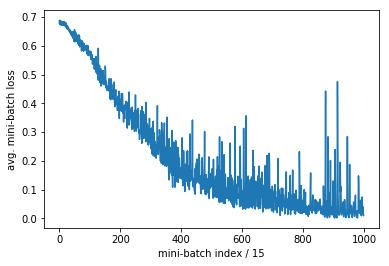

In [37]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [38]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(total)
print('Accuracy of the network on the 40 test images: %d %%' % (100 * correct / total))

40
Accuracy of the network on the 40 test images: 60 %


In [39]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(40):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(2):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Positive : 50 %
Accuracy of Negative : 65 %


# My Second Approach

In [40]:
transform = transforms.Compose(
 [transforms.ToTensor(),
 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
tensor_x = torch.stack([torch.Tensor(i) for i in X_train]) # transform to torch tensors
tensor_y = torch.from_numpy(Y_train)
trainset = utils.TensorDataset(tensor_x,tensor_y) # create your datset
trainloader = utils.DataLoader(trainset,  batch_size= 40)
tensor_x_test = torch.stack([torch.Tensor(i) for i in X_test]) # transform to torch tensors
tensor_y_test = torch.from_numpy(Y_test)
testset = utils.TensorDataset(tensor_x_test,tensor_y_test) # create your datset
testloader = utils.DataLoader(testset,  batch_size=40)
device = torch.device("cpu")
classes = ('Positive', 'Negative')

In [41]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 40)
        self.fc3 = nn.Linear(40, 2)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=2, bias=True)
)

In [42]:
loss_func = nn.CrossEntropyLoss()
# We use stochastic gradient descent (SGD) as optimizer.
opt = torch.optim.Adam(net.parameters(), lr=0.0005)
#opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
avg_losses = [] # Avg. losses.
epochs = 1000 # Total epochs.
print_freq = 15 # Print frequency.
for epoch in range(epochs): # Loop over the dataset multiple times.
    running_loss = 0.0 # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        inputs = inputs.permute(0, 3, 1, 2)
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients.
        opt.zero_grad()
        # Forward step.
        outputs = net(inputs)
        #print(outputs)
        #print(labels)
        loss = loss_func(outputs, labels)

        # Backward step.
        loss.backward()

        # Optimization step (update the parameters).
        opt.step()
        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several minibatches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0
print('Finished Training.')

[epoch: 0, i:    14] avg mini-batch loss: 0.675
[epoch: 0, i:    29] avg mini-batch loss: 0.685
[epoch: 1, i:    14] avg mini-batch loss: 0.673
[epoch: 1, i:    29] avg mini-batch loss: 0.683
[epoch: 2, i:    14] avg mini-batch loss: 0.672
[epoch: 2, i:    29] avg mini-batch loss: 0.683
[epoch: 3, i:    14] avg mini-batch loss: 0.672
[epoch: 3, i:    29] avg mini-batch loss: 0.683
[epoch: 4, i:    14] avg mini-batch loss: 0.672
[epoch: 4, i:    29] avg mini-batch loss: 0.683
[epoch: 5, i:    14] avg mini-batch loss: 0.672
[epoch: 5, i:    29] avg mini-batch loss: 0.683
[epoch: 6, i:    14] avg mini-batch loss: 0.672
[epoch: 6, i:    29] avg mini-batch loss: 0.682
[epoch: 7, i:    14] avg mini-batch loss: 0.672
[epoch: 7, i:    29] avg mini-batch loss: 0.682
[epoch: 8, i:    14] avg mini-batch loss: 0.671
[epoch: 8, i:    29] avg mini-batch loss: 0.682
[epoch: 9, i:    14] avg mini-batch loss: 0.671
[epoch: 9, i:    29] avg mini-batch loss: 0.681
[epoch: 10, i:    14] avg mini-batch los

[epoch: 84, i:    14] avg mini-batch loss: 0.565
[epoch: 84, i:    29] avg mini-batch loss: 0.547
[epoch: 85, i:    14] avg mini-batch loss: 0.561
[epoch: 85, i:    29] avg mini-batch loss: 0.545
[epoch: 86, i:    14] avg mini-batch loss: 0.558
[epoch: 86, i:    29] avg mini-batch loss: 0.545
[epoch: 87, i:    14] avg mini-batch loss: 0.556
[epoch: 87, i:    29] avg mini-batch loss: 0.543
[epoch: 88, i:    14] avg mini-batch loss: 0.553
[epoch: 88, i:    29] avg mini-batch loss: 0.540
[epoch: 89, i:    14] avg mini-batch loss: 0.552
[epoch: 89, i:    29] avg mini-batch loss: 0.537
[epoch: 90, i:    14] avg mini-batch loss: 0.545
[epoch: 90, i:    29] avg mini-batch loss: 0.533
[epoch: 91, i:    14] avg mini-batch loss: 0.543
[epoch: 91, i:    29] avg mini-batch loss: 0.532
[epoch: 92, i:    14] avg mini-batch loss: 0.539
[epoch: 92, i:    29] avg mini-batch loss: 0.532
[epoch: 93, i:    14] avg mini-batch loss: 0.541
[epoch: 93, i:    29] avg mini-batch loss: 0.535
[epoch: 94, i:    14

[epoch: 166, i:    29] avg mini-batch loss: 0.325
[epoch: 167, i:    14] avg mini-batch loss: 0.290
[epoch: 167, i:    29] avg mini-batch loss: 0.318
[epoch: 168, i:    14] avg mini-batch loss: 0.270
[epoch: 168, i:    29] avg mini-batch loss: 0.327
[epoch: 169, i:    14] avg mini-batch loss: 0.271
[epoch: 169, i:    29] avg mini-batch loss: 0.323
[epoch: 170, i:    14] avg mini-batch loss: 0.261
[epoch: 170, i:    29] avg mini-batch loss: 0.314
[epoch: 171, i:    14] avg mini-batch loss: 0.258
[epoch: 171, i:    29] avg mini-batch loss: 0.299
[epoch: 172, i:    14] avg mini-batch loss: 0.252
[epoch: 172, i:    29] avg mini-batch loss: 0.292
[epoch: 173, i:    14] avg mini-batch loss: 0.250
[epoch: 173, i:    29] avg mini-batch loss: 0.289
[epoch: 174, i:    14] avg mini-batch loss: 0.248
[epoch: 174, i:    29] avg mini-batch loss: 0.287
[epoch: 175, i:    14] avg mini-batch loss: 0.243
[epoch: 175, i:    29] avg mini-batch loss: 0.284
[epoch: 176, i:    14] avg mini-batch loss: 0.243


[epoch: 248, i:    29] avg mini-batch loss: 0.130
[epoch: 249, i:    14] avg mini-batch loss: 0.122
[epoch: 249, i:    29] avg mini-batch loss: 0.130
[epoch: 250, i:    14] avg mini-batch loss: 0.120
[epoch: 250, i:    29] avg mini-batch loss: 0.129
[epoch: 251, i:    14] avg mini-batch loss: 0.118
[epoch: 251, i:    29] avg mini-batch loss: 0.128
[epoch: 252, i:    14] avg mini-batch loss: 0.119
[epoch: 252, i:    29] avg mini-batch loss: 0.130
[epoch: 253, i:    14] avg mini-batch loss: 0.118
[epoch: 253, i:    29] avg mini-batch loss: 0.129
[epoch: 254, i:    14] avg mini-batch loss: 0.118
[epoch: 254, i:    29] avg mini-batch loss: 0.128
[epoch: 255, i:    14] avg mini-batch loss: 0.119
[epoch: 255, i:    29] avg mini-batch loss: 0.129
[epoch: 256, i:    14] avg mini-batch loss: 0.117
[epoch: 256, i:    29] avg mini-batch loss: 0.132
[epoch: 257, i:    14] avg mini-batch loss: 0.119
[epoch: 257, i:    29] avg mini-batch loss: 0.124
[epoch: 258, i:    14] avg mini-batch loss: 0.123


[epoch: 330, i:    29] avg mini-batch loss: 0.085
[epoch: 331, i:    14] avg mini-batch loss: 0.081
[epoch: 331, i:    29] avg mini-batch loss: 0.111
[epoch: 332, i:    14] avg mini-batch loss: 0.094
[epoch: 332, i:    29] avg mini-batch loss: 0.103
[epoch: 333, i:    14] avg mini-batch loss: 0.107
[epoch: 333, i:    29] avg mini-batch loss: 0.120
[epoch: 334, i:    14] avg mini-batch loss: 0.097
[epoch: 334, i:    29] avg mini-batch loss: 0.101
[epoch: 335, i:    14] avg mini-batch loss: 0.134
[epoch: 335, i:    29] avg mini-batch loss: 0.149
[epoch: 336, i:    14] avg mini-batch loss: 0.119
[epoch: 336, i:    29] avg mini-batch loss: 0.159
[epoch: 337, i:    14] avg mini-batch loss: 0.095
[epoch: 337, i:    29] avg mini-batch loss: 0.138
[epoch: 338, i:    14] avg mini-batch loss: 0.184
[epoch: 338, i:    29] avg mini-batch loss: 0.188
[epoch: 339, i:    14] avg mini-batch loss: 0.215
[epoch: 339, i:    29] avg mini-batch loss: 0.099
[epoch: 340, i:    14] avg mini-batch loss: 0.113


[epoch: 412, i:    29] avg mini-batch loss: 0.017
[epoch: 413, i:    14] avg mini-batch loss: 0.010
[epoch: 413, i:    29] avg mini-batch loss: 0.016
[epoch: 414, i:    14] avg mini-batch loss: 0.010
[epoch: 414, i:    29] avg mini-batch loss: 0.016
[epoch: 415, i:    14] avg mini-batch loss: 0.010
[epoch: 415, i:    29] avg mini-batch loss: 0.015
[epoch: 416, i:    14] avg mini-batch loss: 0.011
[epoch: 416, i:    29] avg mini-batch loss: 0.016
[epoch: 417, i:    14] avg mini-batch loss: 0.012
[epoch: 417, i:    29] avg mini-batch loss: 0.017
[epoch: 418, i:    14] avg mini-batch loss: 0.010
[epoch: 418, i:    29] avg mini-batch loss: 0.014
[epoch: 419, i:    14] avg mini-batch loss: 0.009
[epoch: 419, i:    29] avg mini-batch loss: 0.014
[epoch: 420, i:    14] avg mini-batch loss: 0.011
[epoch: 420, i:    29] avg mini-batch loss: 0.014
[epoch: 421, i:    14] avg mini-batch loss: 0.009
[epoch: 421, i:    29] avg mini-batch loss: 0.015
[epoch: 422, i:    14] avg mini-batch loss: 0.012


[epoch: 494, i:    29] avg mini-batch loss: 0.102
[epoch: 495, i:    14] avg mini-batch loss: 0.089
[epoch: 495, i:    29] avg mini-batch loss: 0.051
[epoch: 496, i:    14] avg mini-batch loss: 0.033
[epoch: 496, i:    29] avg mini-batch loss: 0.033
[epoch: 497, i:    14] avg mini-batch loss: 0.039
[epoch: 497, i:    29] avg mini-batch loss: 0.041
[epoch: 498, i:    14] avg mini-batch loss: 0.021
[epoch: 498, i:    29] avg mini-batch loss: 0.021
[epoch: 499, i:    14] avg mini-batch loss: 0.016
[epoch: 499, i:    29] avg mini-batch loss: 0.032
[epoch: 500, i:    14] avg mini-batch loss: 0.022
[epoch: 500, i:    29] avg mini-batch loss: 0.020
[epoch: 501, i:    14] avg mini-batch loss: 0.015
[epoch: 501, i:    29] avg mini-batch loss: 0.013
[epoch: 502, i:    14] avg mini-batch loss: 0.009
[epoch: 502, i:    29] avg mini-batch loss: 0.015
[epoch: 503, i:    14] avg mini-batch loss: 0.011
[epoch: 503, i:    29] avg mini-batch loss: 0.014
[epoch: 504, i:    14] avg mini-batch loss: 0.008


[epoch: 576, i:    29] avg mini-batch loss: 0.310
[epoch: 577, i:    14] avg mini-batch loss: 0.273
[epoch: 577, i:    29] avg mini-batch loss: 0.252
[epoch: 578, i:    14] avg mini-batch loss: 0.144
[epoch: 578, i:    29] avg mini-batch loss: 0.078
[epoch: 579, i:    14] avg mini-batch loss: 0.072
[epoch: 579, i:    29] avg mini-batch loss: 0.050
[epoch: 580, i:    14] avg mini-batch loss: 0.060
[epoch: 580, i:    29] avg mini-batch loss: 0.101
[epoch: 581, i:    14] avg mini-batch loss: 0.071
[epoch: 581, i:    29] avg mini-batch loss: 0.051
[epoch: 582, i:    14] avg mini-batch loss: 0.046
[epoch: 582, i:    29] avg mini-batch loss: 0.034
[epoch: 583, i:    14] avg mini-batch loss: 0.025
[epoch: 583, i:    29] avg mini-batch loss: 0.039
[epoch: 584, i:    14] avg mini-batch loss: 0.038
[epoch: 584, i:    29] avg mini-batch loss: 0.039
[epoch: 585, i:    14] avg mini-batch loss: 0.033
[epoch: 585, i:    29] avg mini-batch loss: 0.020
[epoch: 586, i:    14] avg mini-batch loss: 0.012


[epoch: 658, i:    29] avg mini-batch loss: 0.013
[epoch: 659, i:    14] avg mini-batch loss: 0.007
[epoch: 659, i:    29] avg mini-batch loss: 0.010
[epoch: 660, i:    14] avg mini-batch loss: 0.008
[epoch: 660, i:    29] avg mini-batch loss: 0.017
[epoch: 661, i:    14] avg mini-batch loss: 0.009
[epoch: 661, i:    29] avg mini-batch loss: 0.013
[epoch: 662, i:    14] avg mini-batch loss: 0.010
[epoch: 662, i:    29] avg mini-batch loss: 0.015
[epoch: 663, i:    14] avg mini-batch loss: 0.010
[epoch: 663, i:    29] avg mini-batch loss: 0.010
[epoch: 664, i:    14] avg mini-batch loss: 0.010
[epoch: 664, i:    29] avg mini-batch loss: 0.012
[epoch: 665, i:    14] avg mini-batch loss: 0.009
[epoch: 665, i:    29] avg mini-batch loss: 0.010
[epoch: 666, i:    14] avg mini-batch loss: 0.009
[epoch: 666, i:    29] avg mini-batch loss: 0.010
[epoch: 667, i:    14] avg mini-batch loss: 0.008
[epoch: 667, i:    29] avg mini-batch loss: 0.009
[epoch: 668, i:    14] avg mini-batch loss: 0.010


[epoch: 740, i:    29] avg mini-batch loss: 0.277
[epoch: 741, i:    14] avg mini-batch loss: 0.196
[epoch: 741, i:    29] avg mini-batch loss: 0.097
[epoch: 742, i:    14] avg mini-batch loss: 0.057
[epoch: 742, i:    29] avg mini-batch loss: 0.049
[epoch: 743, i:    14] avg mini-batch loss: 0.034
[epoch: 743, i:    29] avg mini-batch loss: 0.028
[epoch: 744, i:    14] avg mini-batch loss: 0.024
[epoch: 744, i:    29] avg mini-batch loss: 0.020
[epoch: 745, i:    14] avg mini-batch loss: 0.018
[epoch: 745, i:    29] avg mini-batch loss: 0.024
[epoch: 746, i:    14] avg mini-batch loss: 0.021
[epoch: 746, i:    29] avg mini-batch loss: 0.015
[epoch: 747, i:    14] avg mini-batch loss: 0.007
[epoch: 747, i:    29] avg mini-batch loss: 0.015
[epoch: 748, i:    14] avg mini-batch loss: 0.007
[epoch: 748, i:    29] avg mini-batch loss: 0.007
[epoch: 749, i:    14] avg mini-batch loss: 0.009
[epoch: 749, i:    29] avg mini-batch loss: 0.023
[epoch: 750, i:    14] avg mini-batch loss: 0.017


[epoch: 822, i:    29] avg mini-batch loss: 0.001
[epoch: 823, i:    14] avg mini-batch loss: 0.001
[epoch: 823, i:    29] avg mini-batch loss: 0.001
[epoch: 824, i:    14] avg mini-batch loss: 0.001
[epoch: 824, i:    29] avg mini-batch loss: 0.001
[epoch: 825, i:    14] avg mini-batch loss: 0.001
[epoch: 825, i:    29] avg mini-batch loss: 0.001
[epoch: 826, i:    14] avg mini-batch loss: 0.001
[epoch: 826, i:    29] avg mini-batch loss: 0.001
[epoch: 827, i:    14] avg mini-batch loss: 0.001
[epoch: 827, i:    29] avg mini-batch loss: 0.001
[epoch: 828, i:    14] avg mini-batch loss: 0.001
[epoch: 828, i:    29] avg mini-batch loss: 0.001
[epoch: 829, i:    14] avg mini-batch loss: 0.001
[epoch: 829, i:    29] avg mini-batch loss: 0.001
[epoch: 830, i:    14] avg mini-batch loss: 0.001
[epoch: 830, i:    29] avg mini-batch loss: 0.001
[epoch: 831, i:    14] avg mini-batch loss: 0.001
[epoch: 831, i:    29] avg mini-batch loss: 0.001
[epoch: 832, i:    14] avg mini-batch loss: 0.001


[epoch: 904, i:    29] avg mini-batch loss: 0.000
[epoch: 905, i:    14] avg mini-batch loss: 0.000
[epoch: 905, i:    29] avg mini-batch loss: 0.000
[epoch: 906, i:    14] avg mini-batch loss: 0.000
[epoch: 906, i:    29] avg mini-batch loss: 0.000
[epoch: 907, i:    14] avg mini-batch loss: 0.000
[epoch: 907, i:    29] avg mini-batch loss: 0.000
[epoch: 908, i:    14] avg mini-batch loss: 0.000
[epoch: 908, i:    29] avg mini-batch loss: 0.000
[epoch: 909, i:    14] avg mini-batch loss: 0.000
[epoch: 909, i:    29] avg mini-batch loss: 0.000
[epoch: 910, i:    14] avg mini-batch loss: 0.000
[epoch: 910, i:    29] avg mini-batch loss: 0.000
[epoch: 911, i:    14] avg mini-batch loss: 0.000
[epoch: 911, i:    29] avg mini-batch loss: 0.000
[epoch: 912, i:    14] avg mini-batch loss: 0.000
[epoch: 912, i:    29] avg mini-batch loss: 0.000
[epoch: 913, i:    14] avg mini-batch loss: 0.000
[epoch: 913, i:    29] avg mini-batch loss: 0.000
[epoch: 914, i:    14] avg mini-batch loss: 0.000


[epoch: 986, i:    29] avg mini-batch loss: 0.000
[epoch: 987, i:    14] avg mini-batch loss: 0.000
[epoch: 987, i:    29] avg mini-batch loss: 0.000
[epoch: 988, i:    14] avg mini-batch loss: 0.000
[epoch: 988, i:    29] avg mini-batch loss: 0.000
[epoch: 989, i:    14] avg mini-batch loss: 0.000
[epoch: 989, i:    29] avg mini-batch loss: 0.000
[epoch: 990, i:    14] avg mini-batch loss: 0.000
[epoch: 990, i:    29] avg mini-batch loss: 0.000
[epoch: 991, i:    14] avg mini-batch loss: 0.000
[epoch: 991, i:    29] avg mini-batch loss: 0.000
[epoch: 992, i:    14] avg mini-batch loss: 0.000
[epoch: 992, i:    29] avg mini-batch loss: 0.000
[epoch: 993, i:    14] avg mini-batch loss: 0.000
[epoch: 993, i:    29] avg mini-batch loss: 0.000
[epoch: 994, i:    14] avg mini-batch loss: 0.000
[epoch: 994, i:    29] avg mini-batch loss: 0.000
[epoch: 995, i:    14] avg mini-batch loss: 0.000
[epoch: 995, i:    29] avg mini-batch loss: 0.000
[epoch: 996, i:    14] avg mini-batch loss: 0.000


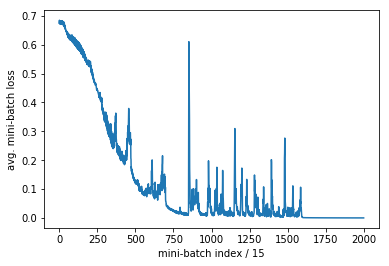

In [43]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [44]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(total)
print('Accuracy of the network on the 40 test images: %d %%' % (100 * correct / total))

40
Accuracy of the network on the 40 test images: 60 %


In [45]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(40):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(2):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Positive : 50 %
Accuracy of Negative : 65 %


In [46]:
transform = transforms.Compose(
 [transforms.ToTensor(),
 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
tensor_x = torch.stack([torch.Tensor(i) for i in X_train]) # transform to torch tensors
tensor_y = torch.from_numpy(Y_train)
trainset = utils.TensorDataset(tensor_x,tensor_y) # create your datset
trainloader = utils.DataLoader(trainset,  batch_size= 40)
tensor_x_test = torch.stack([torch.Tensor(i) for i in X_test]) # transform to torch tensors
tensor_y_test = torch.from_numpy(Y_test)
testset = utils.TensorDataset(tensor_x_test,tensor_y_test) # create your datset
testloader = utils.DataLoader(testset,  batch_size=40)
device = torch.device("cpu")
classes = ('Positive', 'Negative')

In [47]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 40)
        self.fc3 = nn.Linear(40, 2)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=2, bias=True)
)

In [48]:
loss_func = nn.CrossEntropyLoss()
# We use stochastic gradient descent (SGD) as optimizer.
#opt = torch.optim.Adam(net.parameters(), lr=0.001)
opt = optim.Adadelta(net.parameters(), lr=0.5, rho=0.9, eps=1e-06, weight_decay=0)
avg_losses = [] # Avg. losses.
epochs = 500 # Total epochs.
print_freq = 15 # Print frequency.
for epoch in range(epochs): # Loop over the dataset multiple times.
    running_loss = 0.0 # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        inputs = inputs.permute(0, 3, 1, 2)
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients.
        opt.zero_grad()
        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)

        # Backward step.
        loss.backward()

        # Optimization step (update the parameters).
        opt.step()
        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several minibatches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0
print('Finished Training.')

[epoch: 0, i:    14] avg mini-batch loss: 0.682
[epoch: 0, i:    29] avg mini-batch loss: 0.684
[epoch: 1, i:    14] avg mini-batch loss: 0.674
[epoch: 1, i:    29] avg mini-batch loss: 0.685
[epoch: 2, i:    14] avg mini-batch loss: 0.673
[epoch: 2, i:    29] avg mini-batch loss: 0.685
[epoch: 3, i:    14] avg mini-batch loss: 0.673
[epoch: 3, i:    29] avg mini-batch loss: 0.685
[epoch: 4, i:    14] avg mini-batch loss: 0.673
[epoch: 4, i:    29] avg mini-batch loss: 0.684
[epoch: 5, i:    14] avg mini-batch loss: 0.673
[epoch: 5, i:    29] avg mini-batch loss: 0.684
[epoch: 6, i:    14] avg mini-batch loss: 0.672
[epoch: 6, i:    29] avg mini-batch loss: 0.684
[epoch: 7, i:    14] avg mini-batch loss: 0.672
[epoch: 7, i:    29] avg mini-batch loss: 0.684
[epoch: 8, i:    14] avg mini-batch loss: 0.672
[epoch: 8, i:    29] avg mini-batch loss: 0.684
[epoch: 9, i:    14] avg mini-batch loss: 0.672
[epoch: 9, i:    29] avg mini-batch loss: 0.683
[epoch: 10, i:    14] avg mini-batch los

[epoch: 84, i:    14] avg mini-batch loss: 0.469
[epoch: 84, i:    29] avg mini-batch loss: 0.492
[epoch: 85, i:    14] avg mini-batch loss: 0.476
[epoch: 85, i:    29] avg mini-batch loss: 0.470
[epoch: 86, i:    14] avg mini-batch loss: 0.454
[epoch: 86, i:    29] avg mini-batch loss: 0.473
[epoch: 87, i:    14] avg mini-batch loss: 0.451
[epoch: 87, i:    29] avg mini-batch loss: 0.465
[epoch: 88, i:    14] avg mini-batch loss: 0.446
[epoch: 88, i:    29] avg mini-batch loss: 0.488
[epoch: 89, i:    14] avg mini-batch loss: 0.429
[epoch: 89, i:    29] avg mini-batch loss: 0.466
[epoch: 90, i:    14] avg mini-batch loss: 0.457
[epoch: 90, i:    29] avg mini-batch loss: 0.449
[epoch: 91, i:    14] avg mini-batch loss: 0.436
[epoch: 91, i:    29] avg mini-batch loss: 0.442
[epoch: 92, i:    14] avg mini-batch loss: 0.414
[epoch: 92, i:    29] avg mini-batch loss: 0.462
[epoch: 93, i:    14] avg mini-batch loss: 0.426
[epoch: 93, i:    29] avg mini-batch loss: 0.438
[epoch: 94, i:    14

[epoch: 166, i:    29] avg mini-batch loss: 0.303
[epoch: 167, i:    14] avg mini-batch loss: 0.152
[epoch: 167, i:    29] avg mini-batch loss: 0.257
[epoch: 168, i:    14] avg mini-batch loss: 0.211
[epoch: 168, i:    29] avg mini-batch loss: 0.206
[epoch: 169, i:    14] avg mini-batch loss: 0.151
[epoch: 169, i:    29] avg mini-batch loss: 0.204
[epoch: 170, i:    14] avg mini-batch loss: 0.138
[epoch: 170, i:    29] avg mini-batch loss: 0.173
[epoch: 171, i:    14] avg mini-batch loss: 0.339
[epoch: 171, i:    29] avg mini-batch loss: 0.223
[epoch: 172, i:    14] avg mini-batch loss: 0.146
[epoch: 172, i:    29] avg mini-batch loss: 0.187
[epoch: 173, i:    14] avg mini-batch loss: 0.135
[epoch: 173, i:    29] avg mini-batch loss: 0.265
[epoch: 174, i:    14] avg mini-batch loss: 0.140
[epoch: 174, i:    29] avg mini-batch loss: 0.181
[epoch: 175, i:    14] avg mini-batch loss: 0.195
[epoch: 175, i:    29] avg mini-batch loss: 0.200
[epoch: 176, i:    14] avg mini-batch loss: 0.155


[epoch: 248, i:    29] avg mini-batch loss: 0.210
[epoch: 249, i:    14] avg mini-batch loss: 0.109
[epoch: 249, i:    29] avg mini-batch loss: 0.087
[epoch: 250, i:    14] avg mini-batch loss: 0.075
[epoch: 250, i:    29] avg mini-batch loss: 0.109
[epoch: 251, i:    14] avg mini-batch loss: 0.079
[epoch: 251, i:    29] avg mini-batch loss: 0.075
[epoch: 252, i:    14] avg mini-batch loss: 0.040
[epoch: 252, i:    29] avg mini-batch loss: 0.072
[epoch: 253, i:    14] avg mini-batch loss: 0.156
[epoch: 253, i:    29] avg mini-batch loss: 0.074
[epoch: 254, i:    14] avg mini-batch loss: 0.041
[epoch: 254, i:    29] avg mini-batch loss: 0.065
[epoch: 255, i:    14] avg mini-batch loss: 0.066
[epoch: 255, i:    29] avg mini-batch loss: 0.116
[epoch: 256, i:    14] avg mini-batch loss: 0.072
[epoch: 256, i:    29] avg mini-batch loss: 0.085
[epoch: 257, i:    14] avg mini-batch loss: 0.114
[epoch: 257, i:    29] avg mini-batch loss: 0.092
[epoch: 258, i:    14] avg mini-batch loss: 0.151


[epoch: 330, i:    29] avg mini-batch loss: 0.046
[epoch: 331, i:    14] avg mini-batch loss: 0.049
[epoch: 331, i:    29] avg mini-batch loss: 0.039
[epoch: 332, i:    14] avg mini-batch loss: 0.058
[epoch: 332, i:    29] avg mini-batch loss: 0.029
[epoch: 333, i:    14] avg mini-batch loss: 0.067
[epoch: 333, i:    29] avg mini-batch loss: 0.044
[epoch: 334, i:    14] avg mini-batch loss: 0.027
[epoch: 334, i:    29] avg mini-batch loss: 0.123
[epoch: 335, i:    14] avg mini-batch loss: 0.044
[epoch: 335, i:    29] avg mini-batch loss: 0.051
[epoch: 336, i:    14] avg mini-batch loss: 0.055
[epoch: 336, i:    29] avg mini-batch loss: 0.146
[epoch: 337, i:    14] avg mini-batch loss: 0.031
[epoch: 337, i:    29] avg mini-batch loss: 0.055
[epoch: 338, i:    14] avg mini-batch loss: 0.031
[epoch: 338, i:    29] avg mini-batch loss: 0.076
[epoch: 339, i:    14] avg mini-batch loss: 0.033
[epoch: 339, i:    29] avg mini-batch loss: 0.045
[epoch: 340, i:    14] avg mini-batch loss: 0.121


[epoch: 412, i:    29] avg mini-batch loss: 0.024
[epoch: 413, i:    14] avg mini-batch loss: 0.020
[epoch: 413, i:    29] avg mini-batch loss: 0.049
[epoch: 414, i:    14] avg mini-batch loss: 0.074
[epoch: 414, i:    29] avg mini-batch loss: 0.041
[epoch: 415, i:    14] avg mini-batch loss: 0.015
[epoch: 415, i:    29] avg mini-batch loss: 0.018
[epoch: 416, i:    14] avg mini-batch loss: 0.025
[epoch: 416, i:    29] avg mini-batch loss: 0.047
[epoch: 417, i:    14] avg mini-batch loss: 0.016
[epoch: 417, i:    29] avg mini-batch loss: 0.015
[epoch: 418, i:    14] avg mini-batch loss: 0.025
[epoch: 418, i:    29] avg mini-batch loss: 0.019
[epoch: 419, i:    14] avg mini-batch loss: 0.017
[epoch: 419, i:    29] avg mini-batch loss: 0.024
[epoch: 420, i:    14] avg mini-batch loss: 0.018
[epoch: 420, i:    29] avg mini-batch loss: 0.031
[epoch: 421, i:    14] avg mini-batch loss: 0.018
[epoch: 421, i:    29] avg mini-batch loss: 0.045
[epoch: 422, i:    14] avg mini-batch loss: 0.080


[epoch: 494, i:    29] avg mini-batch loss: 0.005
[epoch: 495, i:    14] avg mini-batch loss: 0.004
[epoch: 495, i:    29] avg mini-batch loss: 0.094
[epoch: 496, i:    14] avg mini-batch loss: 0.176
[epoch: 496, i:    29] avg mini-batch loss: 0.079
[epoch: 497, i:    14] avg mini-batch loss: 0.013
[epoch: 497, i:    29] avg mini-batch loss: 0.008
[epoch: 498, i:    14] avg mini-batch loss: 0.004
[epoch: 498, i:    29] avg mini-batch loss: 0.008
[epoch: 499, i:    14] avg mini-batch loss: 0.005
[epoch: 499, i:    29] avg mini-batch loss: 0.007
Finished Training.


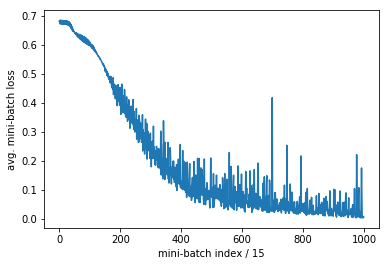

In [49]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [50]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(total)
print('Accuracy of the network on the 40 test images: %d %%' % (100 * correct / total))

40
Accuracy of the network on the 40 test images: 47 %


In [51]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(40):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(2):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Positive : 50 %
Accuracy of Negative : 46 %


# Flatten ML

In [52]:
X_trainFlat = [x.flatten() for x in X_train]
X_testFlat = [x.flatten() for x in X_test]

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier

cls = DecisionTreeClassifier(random_state=0)
cls.fit(X_trainFlat, Y_train)
#print(cls)
pred = cls.predict(X_testFlat)
pred = cls.predict(X_testFlat)
correct = 0
for x in range(len(pred)):
    if pred[x] == Y_test[x]:
        correct+=1
percentage = correct/len(Y_test)
print("Decision Tree accuracy: " + str(percentage))
print()

cls = RandomForestClassifier()
cls.fit(X_trainFlat, Y_train)
#print(cls)
pred = cls.predict(X_testFlat)
pred = cls.predict(X_testFlat)
correct = 0
for x in range(len(pred)):
    if pred[x] == Y_test[x]:
        correct+=1
percentage = correct/len(Y_test)
print("Random Forest accuracy: " + str(percentage))
print()

cls = AdaBoostClassifier()
cls.fit(X_trainFlat, Y_train)
#print(cls)
pred = cls.predict(X_testFlat)
pred = cls.predict(X_testFlat)
correct = 0
for x in range(len(pred)):
    if pred[x] == Y_test[x]:
        correct+=1
percentage = correct/len(Y_test)
print("Ada Boost accuracy: " + str(percentage))
print()

cls = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
cls.fit(X_trainFlat, Y_train)
#print(cls)
pred = cls.predict(X_testFlat)
correct = 0
for x in range(len(pred)):
    if pred[x] == Y_test[x]:
        correct+=1
percentage = correct/len(Y_test)
print("SGD Classifier accuracy: " + str(percentage))
print()

cls = LogisticRegression()
cls.fit(X_trainFlat, Y_train)
#print(cls)
pred = cls.predict(X_testFlat)
correct = 0
for x in range(len(pred)):
    if pred[x] == Y_test[x]:
        correct+=1
percentage = correct/len(Y_test)
print("Logistic Regression accuracy: " + str(percentage))

Decision Tree accuracy: 0.525



/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest accuracy: 0.625

Ada Boost accuracy: 0.55

SGD Classifier accuracy: 0.675



/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression accuracy: 0.7


In [54]:
X_train_vec = []
for i in range(X_train.shape[0]):
    flat = X_train[i,:,:,:].flatten()
    arr = np.array2string(flat)
    X_train_vec.append(arr)
X_test_vec = []
for i in range(X_test.shape[0]):
    flat = X_test[i,:,:,:].flatten()
    arr = np.array2string(flat)
    X_test_vec.append(arr)

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
count_vect = TfidfVectorizer(ngram_range=(1,3))
trainX = count_vect.fit_transform(X_train_vec)
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Y_train)
target_labels = le.classes_
trainy = le.transform(Y_train)

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 5, 10, 25]}
print("grid search start")
grid = GridSearchCV(LogisticRegression(random_state=0, solver='lbfgs',class_weight = 'balanced', max_iter=10000), param_grid, cv=5)
print("done grid search")
grid.fit(trainX, trainy)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
cls = grid.best_estimator_
cls.fit(trainX, trainy)

grid search start
done grid search
Best cross-validation score: 0.41
Best parameters:  {'C': 0.01}
Best estimator:  LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)


LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [57]:
import sklearn.metrics
testX = count_vect.transform(X_test_vec)
yp = cls.predict(testX)
testy = le.transform(Y_test)
acc = sklearn.metrics.accuracy_score(testy, yp)
print("Accuracy for Test for the NLP method is " + str(acc))

Accuracy for Test for the NLP method is 0.35
